# New York City Taxi Trip Duration

Share code and data to improve ride time predictions

## Contents

1. EDA
  1. 데이터 확인
  1. Correlation 분석

1. rough modeling
  - 결과 진단
      1. 잔차 정규성 검정
          - plot (residual - feature)
      1. 이분산 검정
          - scatter plot (residual - feature)
      1. 자기상관 검정
          - PCA 결정
      1. target-feature check
          1. partial regression plot
          1. ccpr plot
1. 컬럼별 최적 정규화
1. modeling
  1. model with outlier
  1. model w/o outlier
  1. 결과 진단
      1. 잔차 정규성 검정
      1. 이분산 검정
      1. 자기상관 검정
      1. target-feature check
1. Cross validation 결과
1. Kaggle 결과
1. 결론

---

In [1]:
from taxi_pakage import *

---

# 1. EDA

## A. Data check

In [2]:
# data set
taxi = pd.read_csv('train.csv')
taxi.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198


In [3]:
# 데이터 크기
taxi.shape # 1,458,644개 데이터, 11개의 컬럼으로 구성

(1458644, 11)

In [4]:
# 데이터에 대한 정보 (컬럼 개수, null값 여부, 데이터 유형)
taxi.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


- object : id, pickup_datetime, dropoff_datetime, store_and_fwd_flag
- int : vendor_id, passenger_count, trip_duration
- float : pickup_logitude, pickup_latitude, dropoff_logitude, dropoff_latitude

| Values | Meaning |
|-|-|
|id | a unique identifier for each trip |
|vendor_id | a code indicating the provider associated with the trip record |
|pickup_datetime|date and time when the meter was engaged |
|dropoff_datetime|date and time when the meter was disengaged|
|passenger_count|the number of passengers in the vehicle (driver entered value)|
|pickup_longitude|the longitude where the meter was engaged|
|pickup_latitude| the latitude where the meter was engaged|
|dropoff_longitude| the longitude where the meter was disngaged|
|dropoff_latitude| the latitude where the meter was disengaged|
|store_and_fwd_flag|This indicates whether the trip record was held in vehicle memory |
|trip_duration|duration of the trip in seconds|

In [5]:
# Descriptive statistics
pd.set_option('display.float_format', lambda x: '%.2f' % x)
taxi.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75,959.49
std,0.50,1.31,0.07,0.03,0.07,0.04,5237.43
min,1.00,0.00,-121.93,34.36,-121.93,32.18,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1075.00
max,2.00,9.00,-61.34,51.88,-61.34,43.92,3526282.00


### 독립 변수

( vendor_id / passenger_count / store_and_fwd_flag )

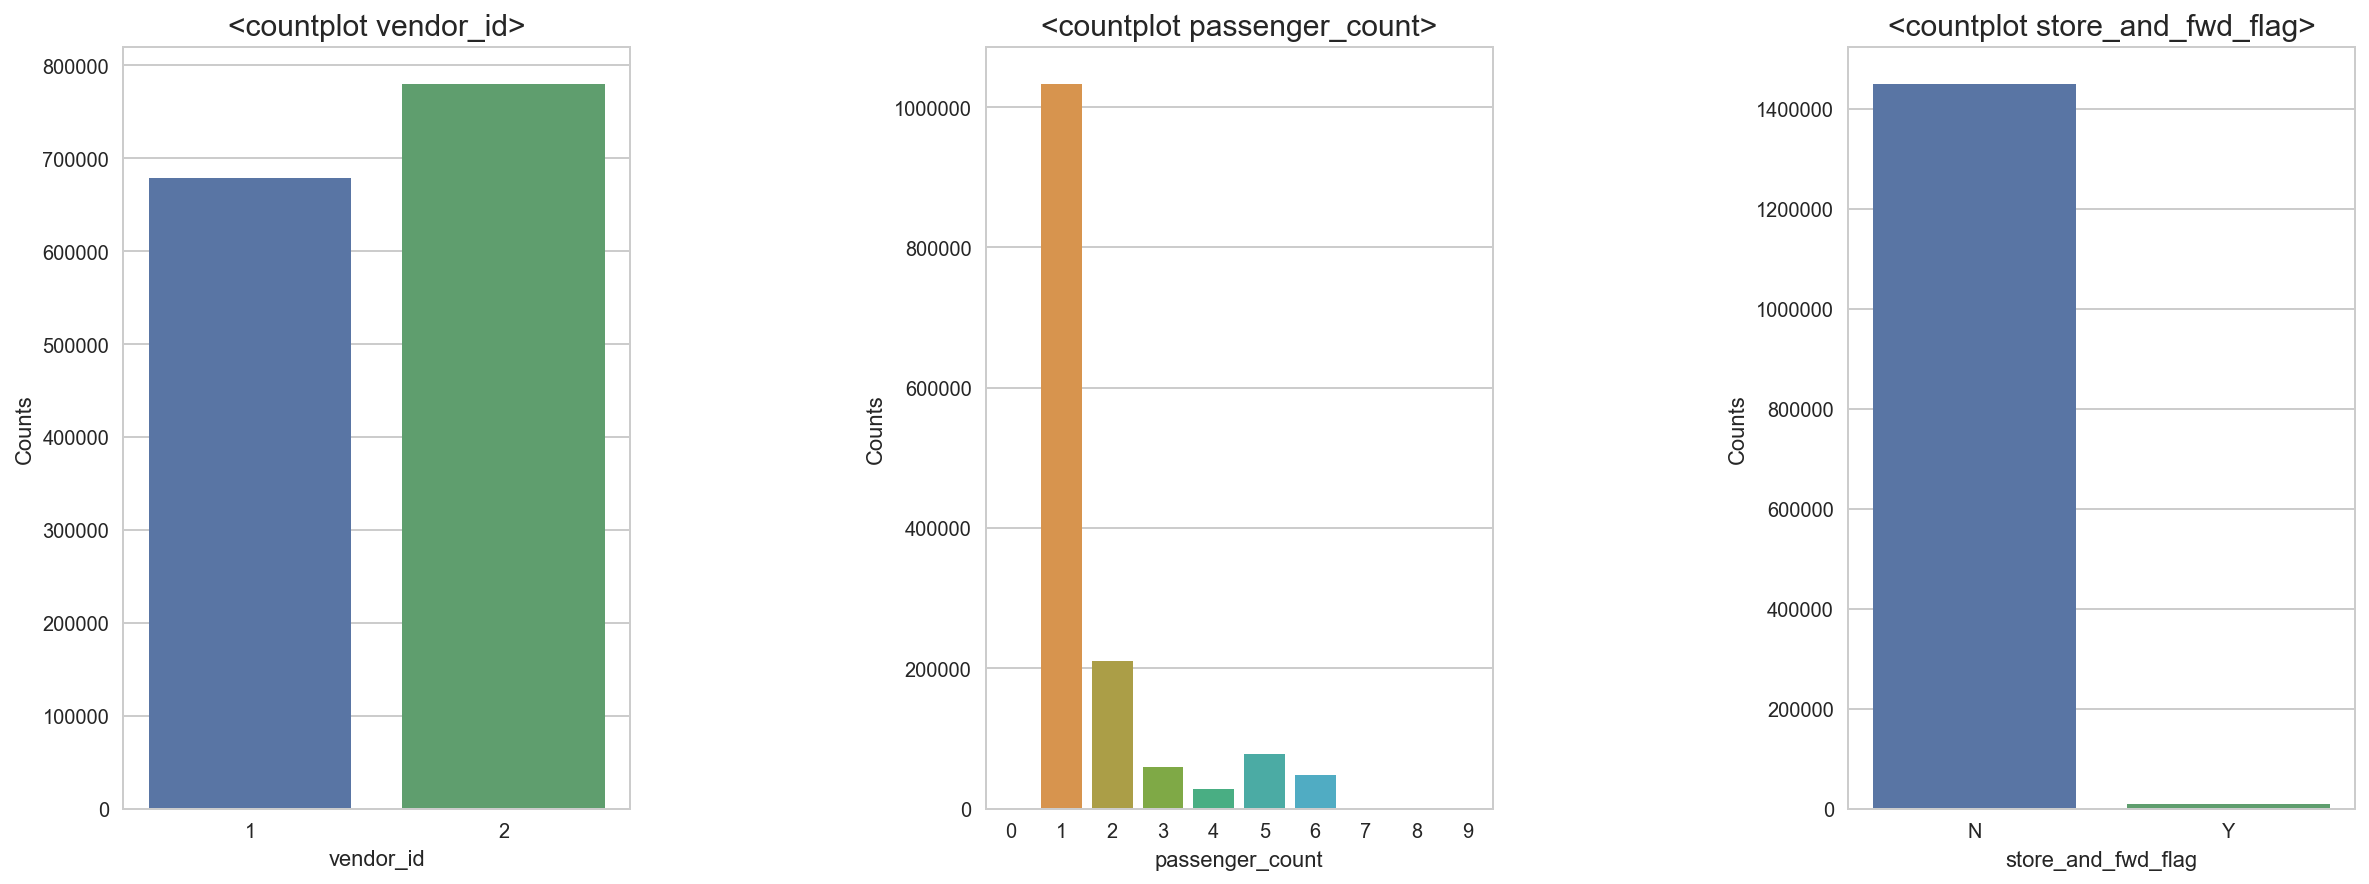

In [6]:
# countplot
plt.figure(figsize=(20, 7))
plt.subplots_adjust(wspace = 0.7)

# vendor_id
plt.subplot(131)
sns.countplot(x = 'vendor_id', data = taxi)
plt.title('<countplot vendor_id>', fontsize = 15)
plt.xlabel('vendor_id')
plt.ylabel('Counts')

# passenger_count
plt.subplot(132)
sns.countplot(x = 'passenger_count', data = taxi)
plt.title('<countplot passenger_count>', fontsize = 15)
plt.xlabel('passenger_count')
plt.ylabel('Counts')

# store_and_fwd_flag
plt.subplot(133)
sns.countplot(x = 'store_and_fwd_flag', data = taxi)
plt.title('<countplot store_and_fwd_flag>', fontsize = 15)
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Counts')

plt.show()

### location
( pickup_longitude / pickup_latitude / dropoff_longitude / dropoff_latitude )

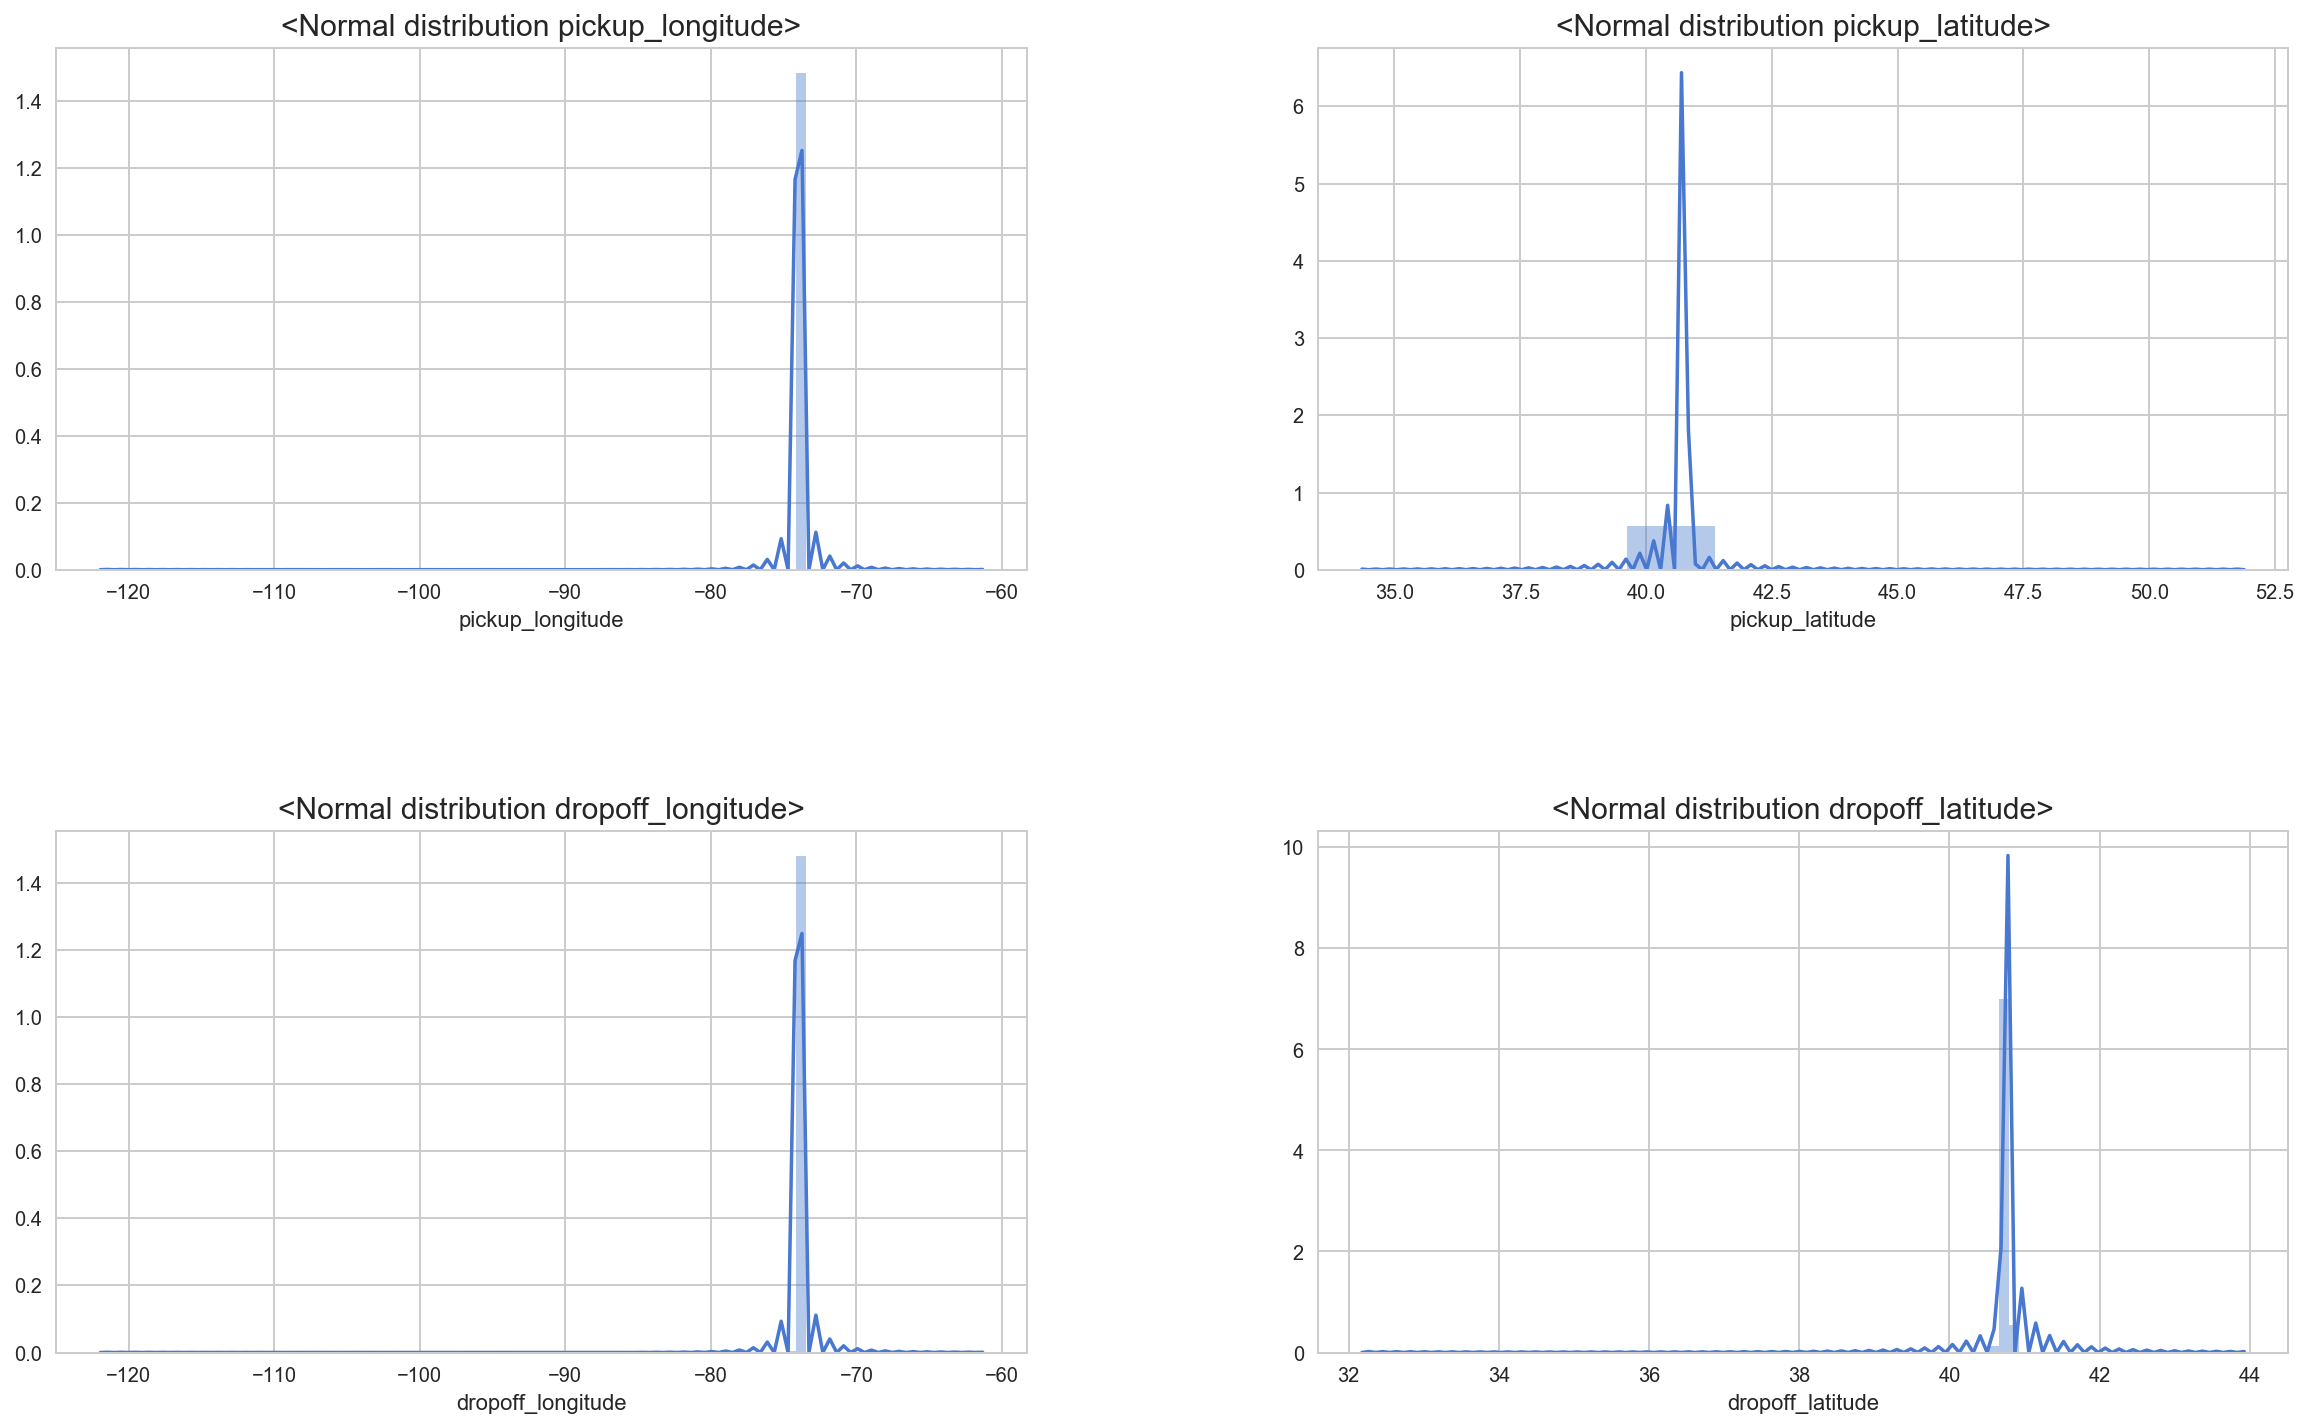

In [7]:
# normal distribution
plt.figure(figsize=(20, 12))
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

# pickup_longitude
plt.subplot(221)
plt.title("<Normal distribution pickup_longitude>", fontsize = 15)
sns.distplot(taxi["pickup_longitude"].values, 
             axlabel = "pickup_longitude", bins = 90, color = "b")


# pickup_latitude
plt.subplot(222)
plt.title("<Normal distribution pickup_latitude>", fontsize = 15)
sns.distplot(taxi["pickup_latitude"].values, 
             axlabel = "pickup_latitude", bins = 10, color = "b")

# dropoff_longitude
plt.subplot(223)
plt.title("<Normal distribution dropoff_longitude>", fontsize = 15)
sns.distplot(taxi["dropoff_longitude"].values, 
             axlabel = "dropoff_longitude", bins = 90, color = "b")

# dropoff_latitude
plt.subplot(224)
plt.title("<Normal distribution dropoff_latitude>", fontsize = 15)
sns.distplot(taxi["dropoff_latitude"].values, 
             axlabel = "dropoff_latitude", bins = 90, color = "b")

plt.show()

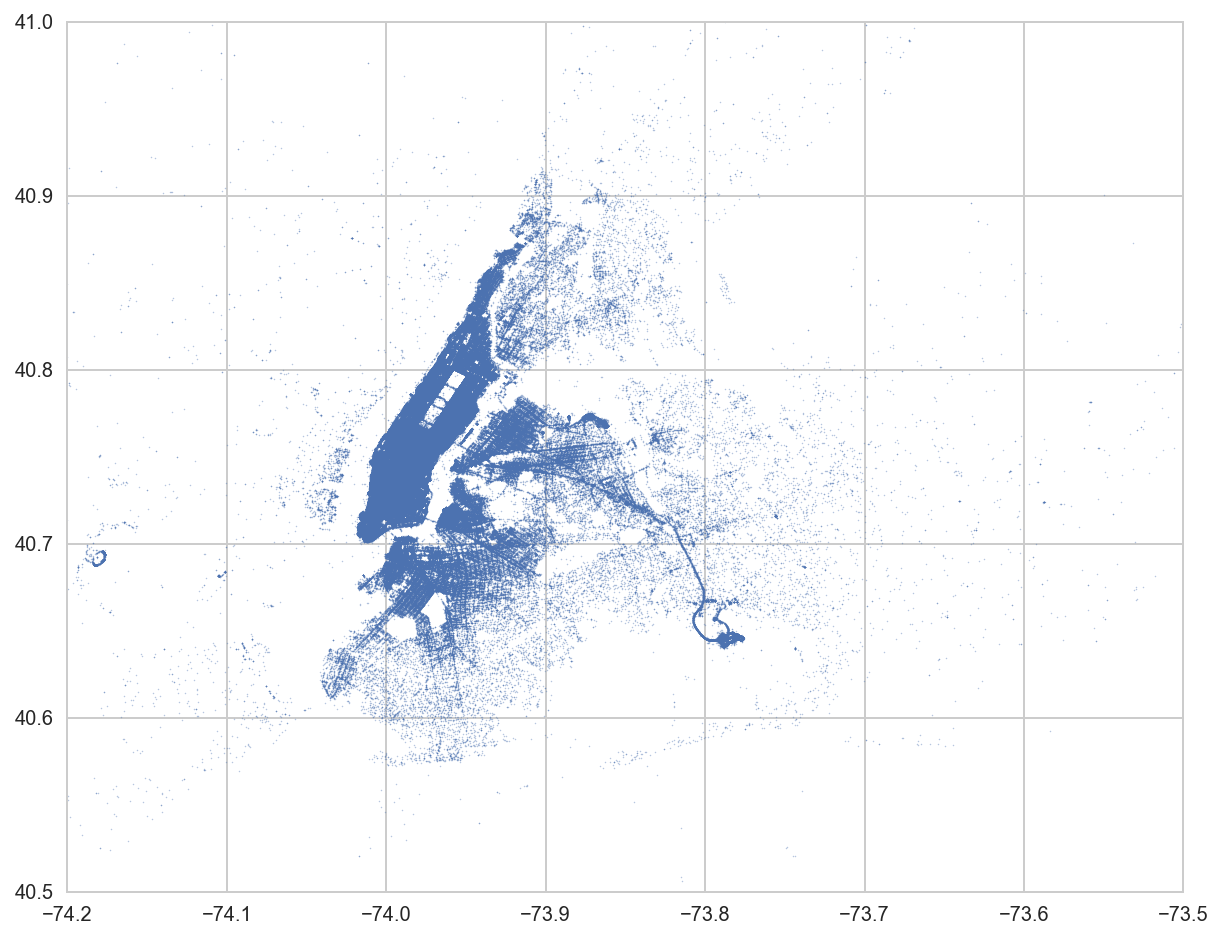

In [8]:
# 좌표 표시
longitude = list(taxi['pickup_longitude']) + list(taxi['dropoff_longitude'])
latitude = list(taxi['pickup_latitude']) + list(taxi['dropoff_latitude'])
plt.figure(figsize = (10, 8))
plt.xlim(-74.2, -73.5)
plt.ylim(40.5, 41)
plt.plot(longitude, latitude, '.', alpha = 0.4, markersize = 1.5)
plt.show()

### 종속 변수

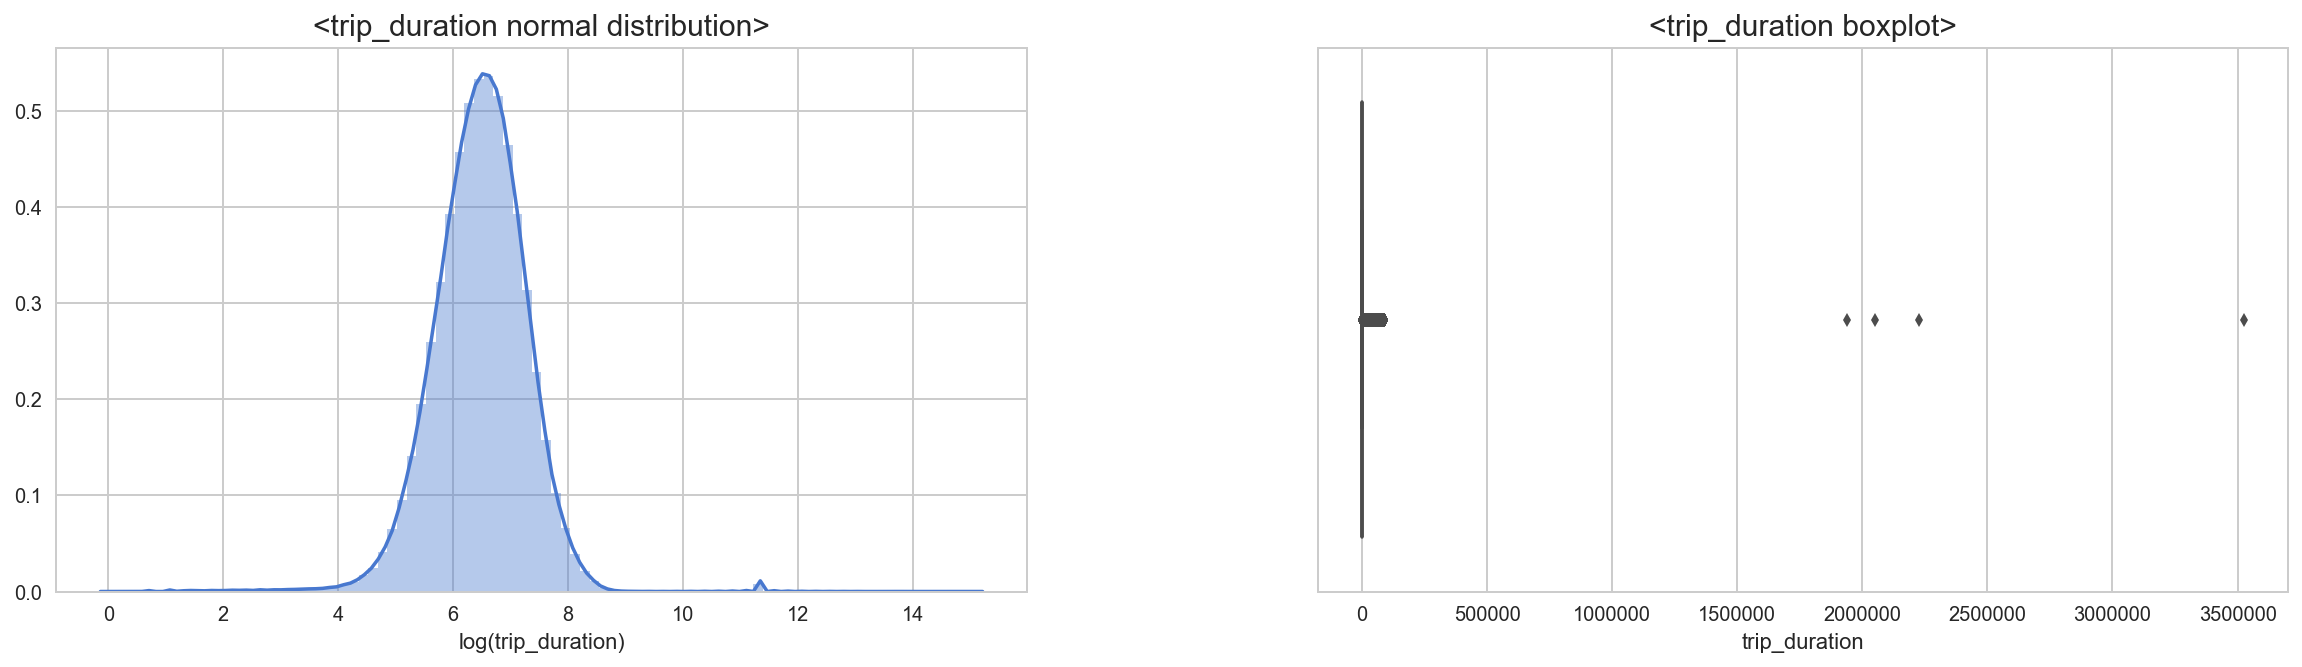

In [9]:
# trip_duration
plt.figure(figsize=(20, 5))
plt.subplots_adjust(wspace = 0.3)

plt.subplot(121)
plt.title("<trip_duration normal distribution>", fontsize = 15)
sns.distplot(np.log(taxi["trip_duration"]).values, 
             axlabel = "log(trip_duration)", label = "trip_duration", bins = 90, color = "b")

plt.subplot(122)
sns.boxplot(x = 'trip_duration', data = taxi)
plt.title('<trip_duration boxplot>', fontsize = 15)
plt.xlabel('trip_duration')

plt.show()

### edit data

In [3]:
# store_and_fwd_flag -  N, Y 를 0, 1 숫자로 변경
taxi['store_and_fwd_flag'] = taxi['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

# pickup_datetime, dropoff_datetime 형식 바꿈 (2016.01.01 기준)
taxi['pickup_datetime'] = taxi['pickup_datetime'].apply(strptime)

### add data

In [5]:
# 좌표를 이용해 직선 거리 생성
taxi['dist'] = haversine_np(taxi['pickup_longitude'], taxi['pickup_latitude'], 
                            taxi['dropoff_longitude'], taxi['dropoff_latitude'])

# date 숫자화
taxi['pick_date'] = taxi['pickup_datetime'].apply(date_to_zero)
taxi['pick_time'] = taxi['pickup_datetime'].apply(time_to_zero)

taxi["pickup_datetime"] = pd.to_datetime(taxi["pickup_datetime"]) 
taxi["month"] = taxi["pickup_datetime"].dt.month 
taxi["hour"] = taxi["pickup_datetime"].dt.hour
taxi["weekday"] = taxi["pickup_datetime"].dt.weekday # 요일 (1:월, 2:화, 3:수, 4:목, 5:금, 6:토, 7:일)
taxi['holiday'] = taxi['pickup_datetime'].apply(holiday) # 휴일 (1:휴일, 0:평일)

#extreme_weather data 추가 입력
weather_event = ['20160110', '20160113', '20160117', '20160123',
                 '20160205', '20160208', '20160215', '20160216',
                 '20160224', '20160225', '20160314', '20160315',
                 '20160328', '20160329', '20160403', '20160404',
                 '20160530', '20160628']

weather_event = pd.Series(pd.to_datetime(weather_event, format = '%Y%m%d')).dt.date
weather_event = weather_event.astype('<U32')
weather_event = list(weather_event)

taxi["y-m-d"] = pd.to_datetime(taxi["pickup_datetime"]).apply(lambda x: x.strftime("%Y-%m-%d"))
taxi["extreme_weather"] = taxi["y-m-d"].apply(lambda x: 1 if x in weather_event else 0)
taxi["weather_event"] = taxi["extreme_weather"]

### setting

In [6]:
# 최종 데이터
# 차후 분석을 위해 연속형 데이터, 카테고리 데이터, y(trip_duration)순으로 재배치
c_1 = taxi['vendor_id']
c_2 = taxi['passenger_count']
c_3 = taxi['store_and_fwd_flag']
c_4 = taxi['month']
c_5 = taxi['hour']
c_6 = taxi['weekday']
c_7 = taxi['holiday']
c_8 = taxi['weather_event']
y = taxi['trip_duration'] 

taxi = taxi.drop(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count' , 'store_and_fwd_flag',  'trip_duration', 'month', 'hour', 'weekday', 'holiday', 'y-m-d', 'extreme_weather', 'weather_event'], axis = 1)

taxi['vendor_id'] = c_1
taxi['passenger_count'] = c_2
taxi['store_and_fwd_flag'] = c_3 
taxi['month'] = c_4 
taxi['hour'] = c_5 
taxi['weekday'] = c_6 
taxi['holiday'] = c_7 
taxi['weather_event'] = c_8
taxi['trip_duration'] = y
taxi.tail()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,pick_date,pick_time,vendor_id,passenger_count,store_and_fwd_flag,month,hour,weekday,holiday,weather_event,trip_duration
1458639,-73.982201,40.745522,-73.994911,40.740170,1.224311,98,48663,2,4,0,4,13,4,0,0,778
1458640,-74.000946,40.747379,-73.970184,40.796547,6.046037,9,27314,1,1,0,1,7,6,0,1,655
1458641,-73.959129,40.768799,-74.004433,40.707371,7.819693,112,25060,2,1,0,4,6,4,0,0,764
1458642,-73.982079,40.749062,-73.974632,40.757107,1.091878,4,57385,1,1,0,1,15,1,0,0,373
1458643,-73.979538,40.781750,-73.972809,40.790585,1.133330,95,53064,1,1,0,4,14,1,0,0,198


# extra data EDA

### month / hour / weekday / holiday / weather_event

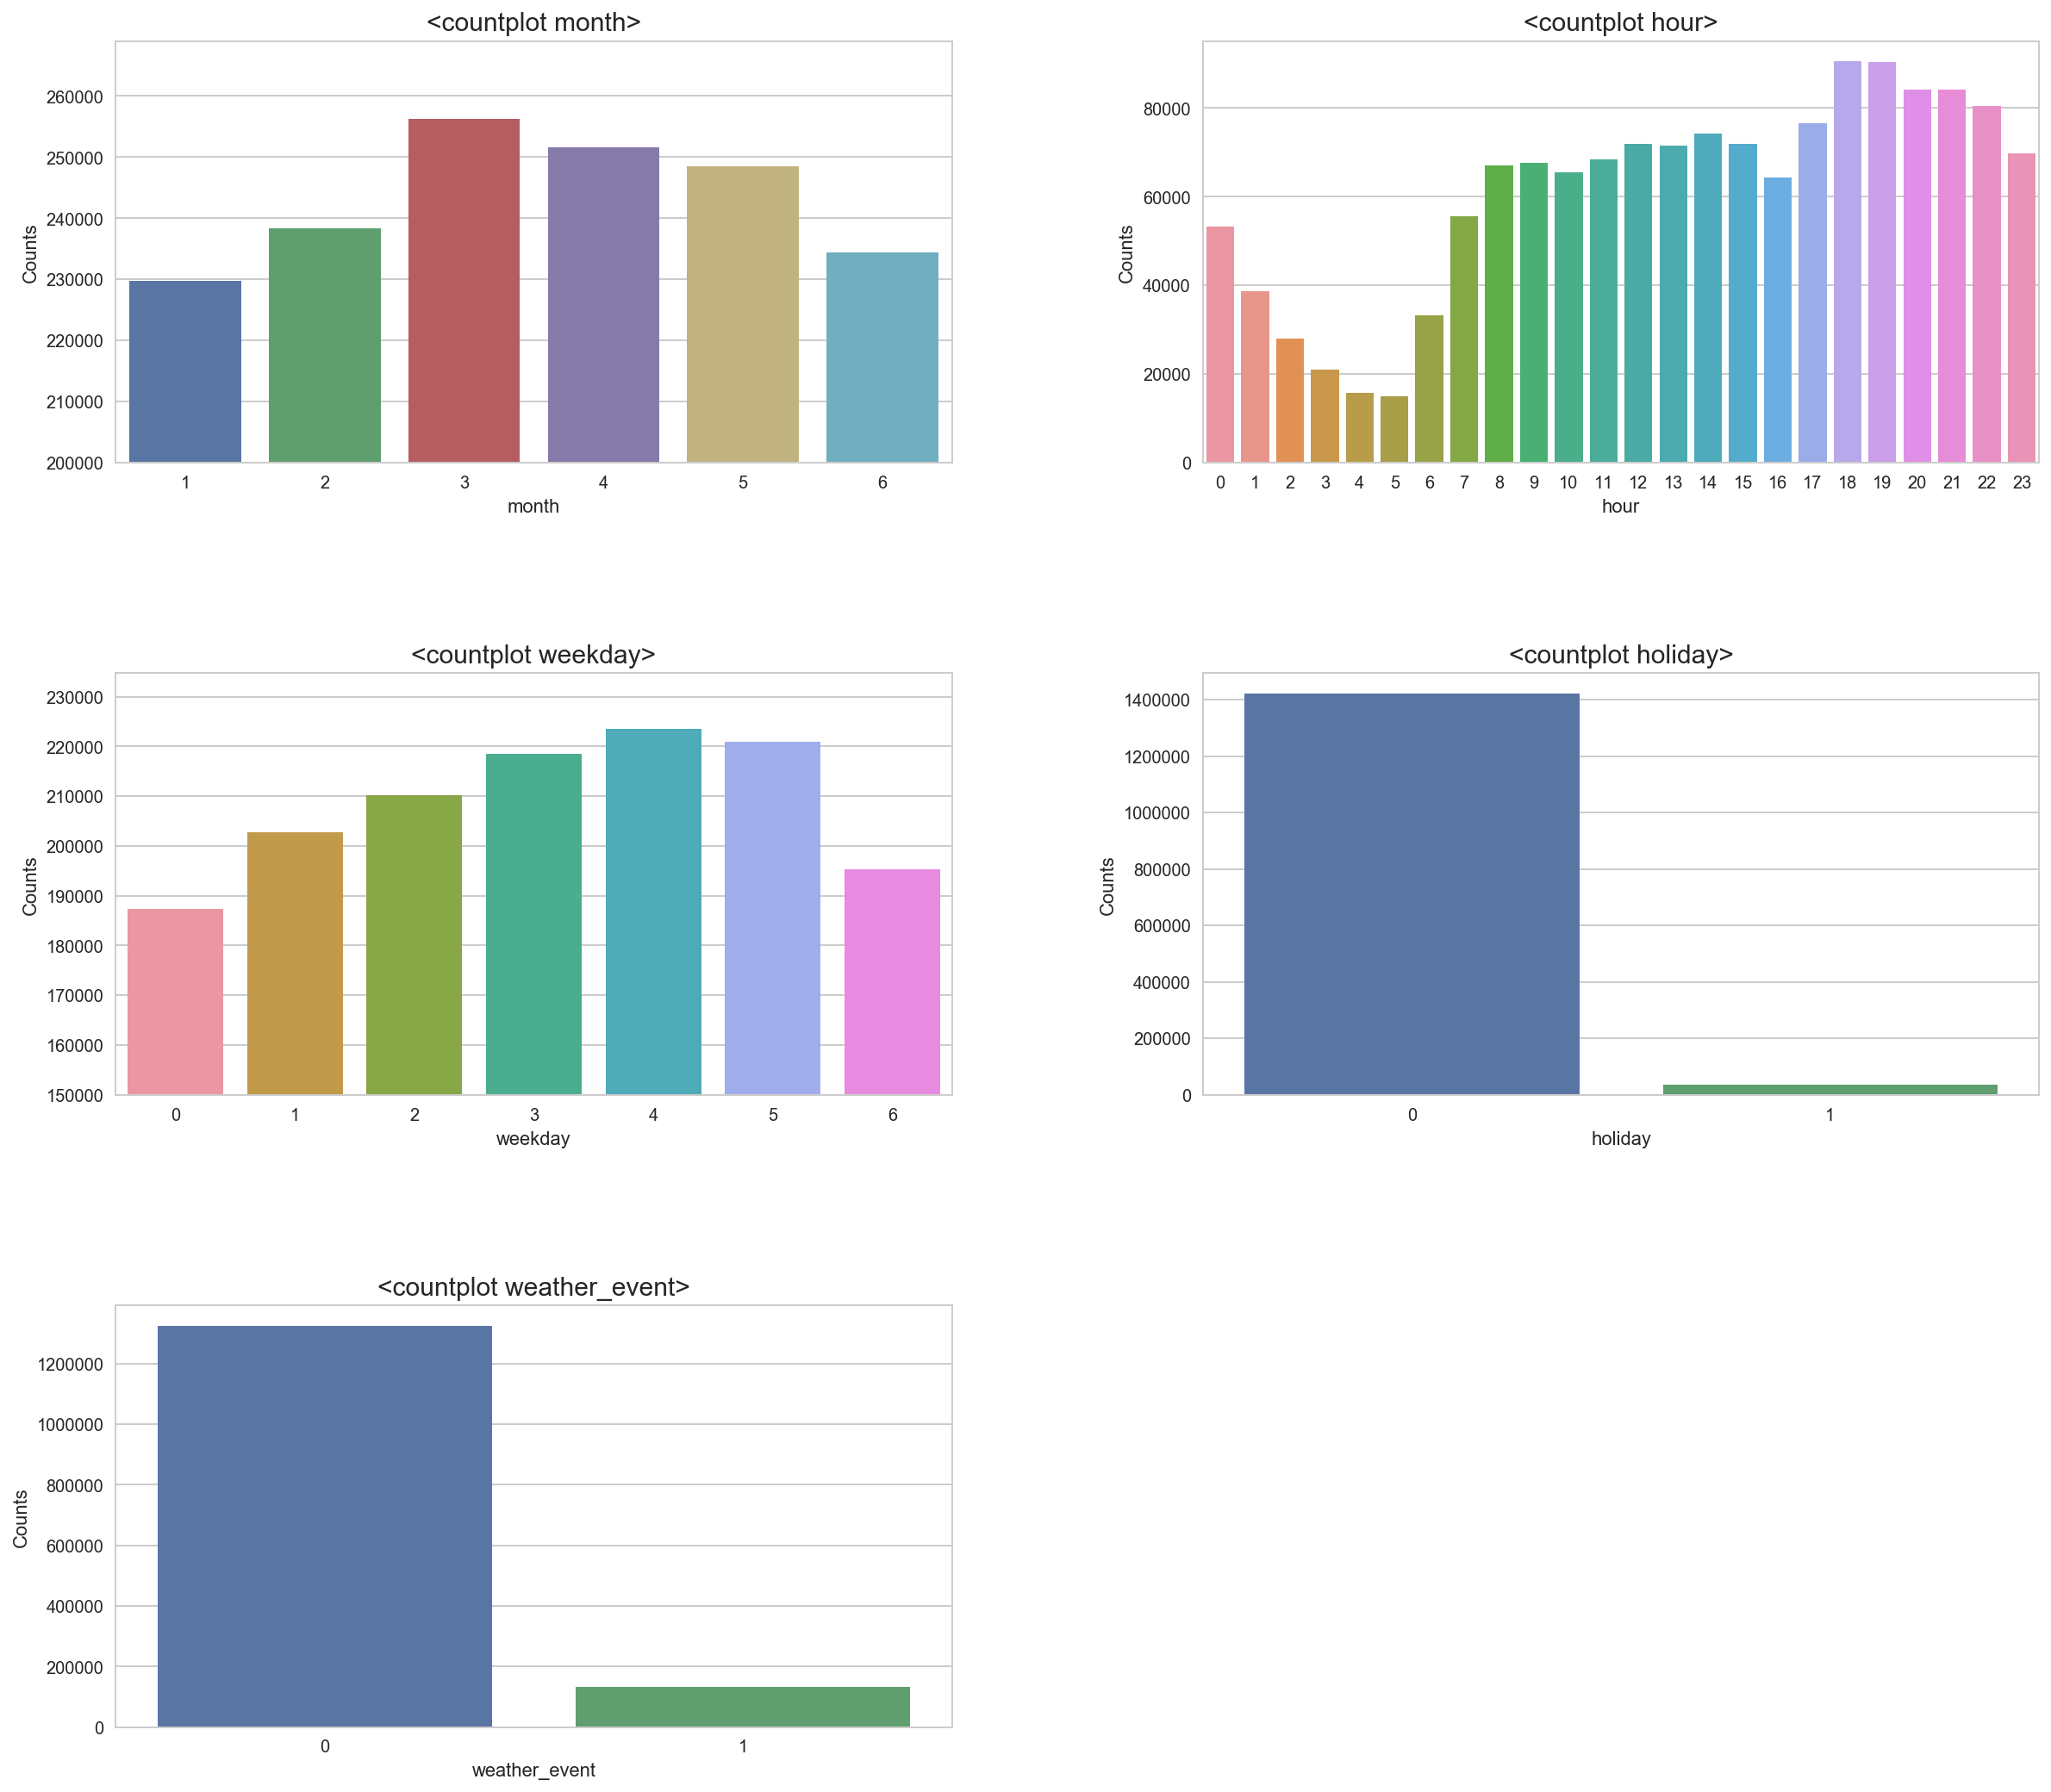

In [13]:
# countplot
plt.figure(figsize=(20, 18))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

# vendor_id
plt.subplot(321)
sns.countplot(x = 'month', data = taxi)
plt.ylim(200000)
plt.title('<countplot month>', fontsize = 15)
plt.xlabel('month')
plt.ylabel('Counts')

# hour
plt.subplot(322)
sns.countplot(x = 'hour', data = taxi)
plt.title('<countplot hour>', fontsize = 15)
plt.xlabel('hour')
plt.ylabel('Counts')

# weekday
plt.subplot(323)
sns.countplot(x = 'weekday', data = taxi)
plt.ylim(150000)
plt.title('<countplot weekday>', fontsize = 15)
plt.xlabel('weekday')
plt.ylabel('Counts')

# holiday
plt.subplot(324)
sns.countplot(x = 'holiday', data = taxi)
plt.title('<countplot holiday>', fontsize = 15)
plt.xlabel('holiday')
plt.ylabel('Counts')

# store_and_fwd_flag
plt.subplot(325)
sns.countplot(x = 'weather_event', data = taxi)
plt.title('<countplot weather_event>', fontsize = 15)
plt.xlabel('weather_event')
plt.ylabel('Counts')

plt.show()

### dist / pick_time / pick_date

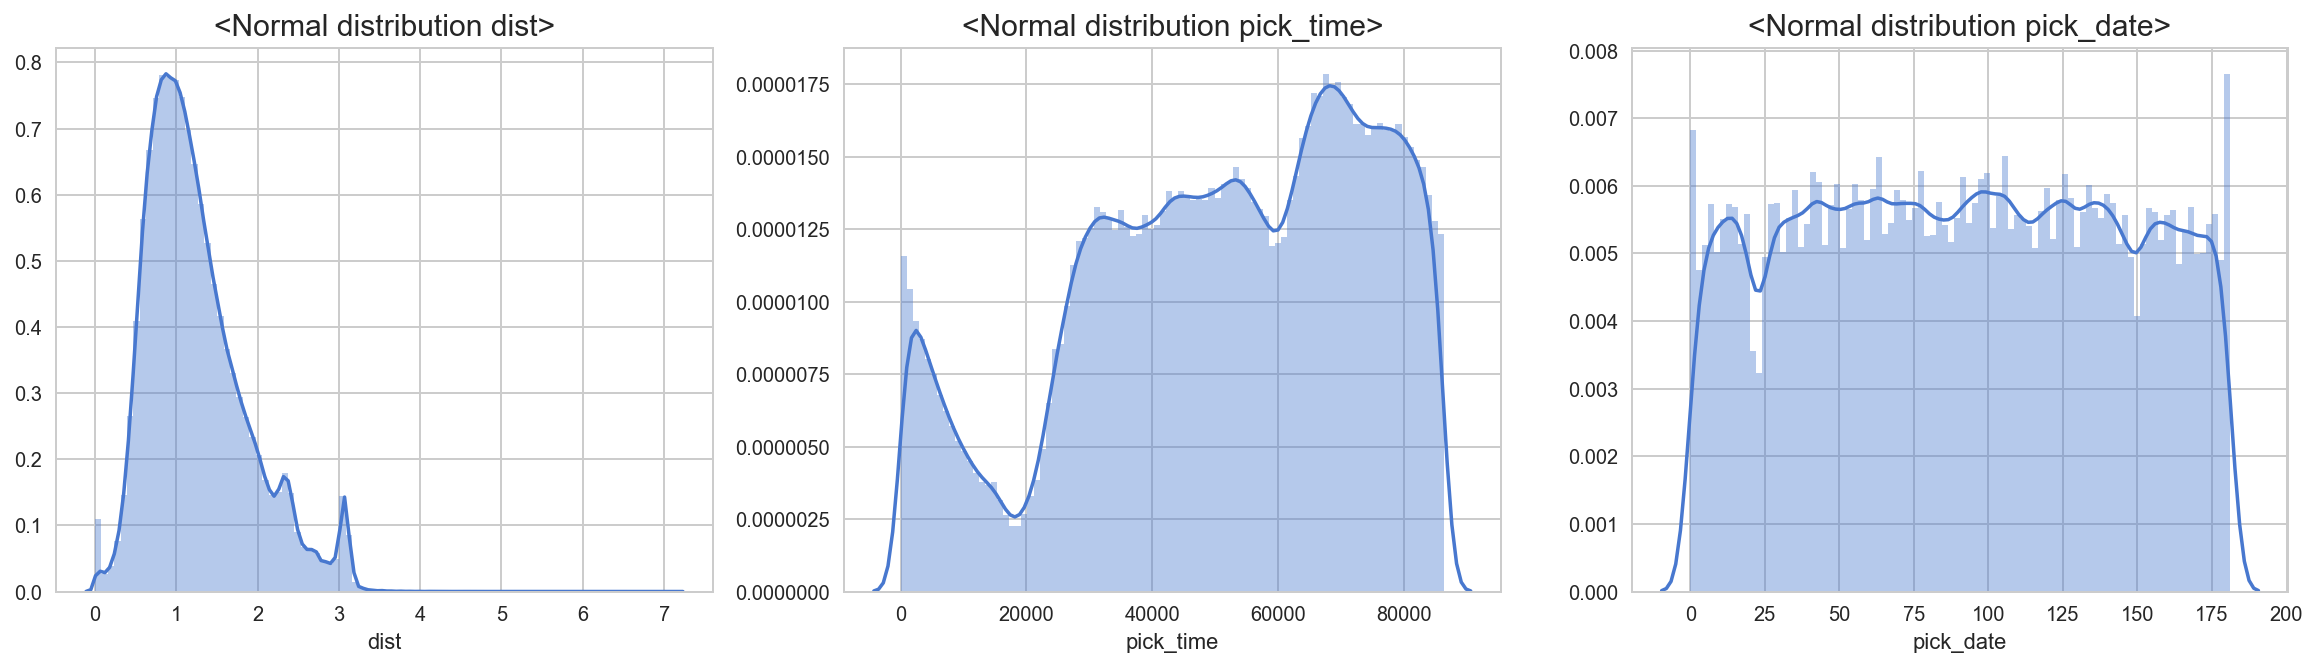

In [14]:
plt.figure(figsize=(20, 5))
plt.subplots_adjust(wspace = 0.2)

# dist
plt.subplot(131)
plt.title("<Normal distribution dist>", fontsize = 15)
sns.distplot(np.log1p(taxi["dist"]).values, 
             axlabel = "dist", label = "dist", bins = 90, color = "b")

# pick_time
plt.subplot(132)
plt.title("<Normal distribution pick_time>", fontsize = 15)
sns.distplot(taxi["pick_time"].values, 
             axlabel = "pick_time", label = "pick_time", bins = 90, color = "b")

# pick_date
plt.subplot(133)
plt.title("<Normal distribution pick_date>", fontsize = 15)
sns.distplot(taxi["pick_date"].values, 
             axlabel = "pick_date", label = "pick_date", bins = 90, color = "b")

plt.show()

### 이상치 제거

In [15]:
# 이상치 체크
taxi[taxi['trip_duration'] > 1500000]

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,pick_date,pick_time,vendor_id,passenger_count,store_and_fwd_flag,month,hour,weekday,holiday,weather_event,trip_duration
355003,-73.79,40.64,-73.96,40.77,20.14,4,1181,1,1,0,1,0,1,0,0,1939736
680594,-73.92,40.74,-73.98,40.76,5.98,43,81479,1,2,0,2,22,5,0,0,2049578
924150,-73.98,40.74,-73.99,40.73,1.63,4,22454,1,1,0,1,6,1,0,0,2227612
978383,-73.78,40.65,-73.98,40.75,19.89,43,82011,1,1,0,2,22,5,0,0,3526282


In [7]:
# Trip_duration에서 나타난 4개의 이상치 제거
taxi = taxi[taxi['trip_duration'] < 1500000].reset_index(drop=True)

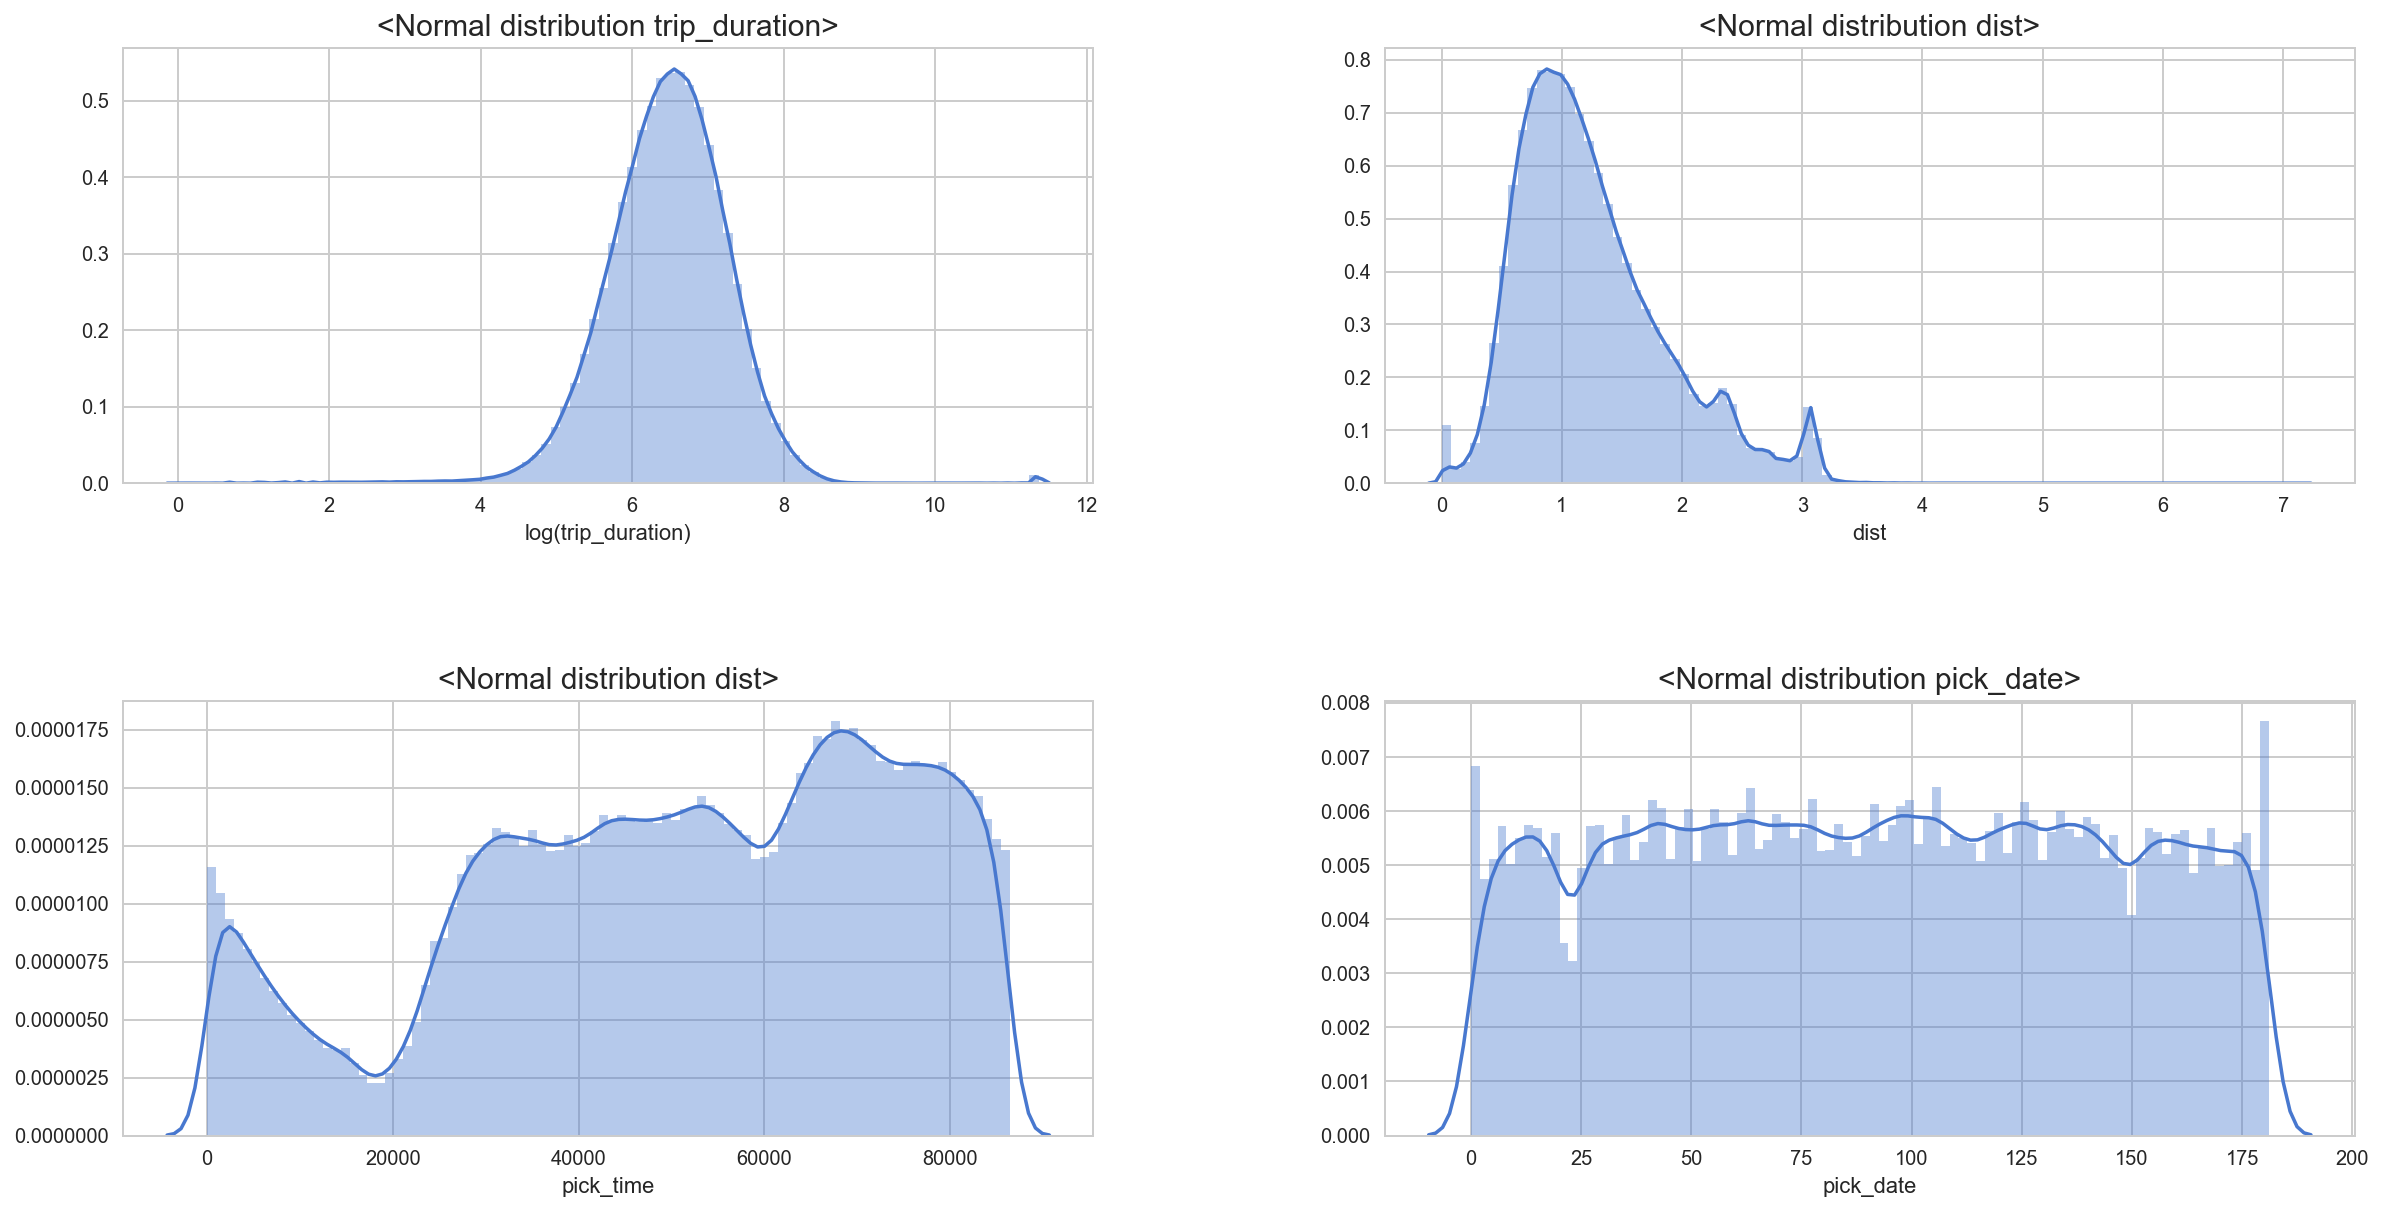

In [17]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

plt.subplot(221)
plt.title("<Normal distribution trip_duration>", fontsize = 15)
sns.distplot(np.log(taxi["trip_duration"]).values, 
             axlabel = "log(trip_duration)", label = "trip_duration", bins = 90, color = "b")

plt.subplot(222)
plt.title("<Normal distribution dist>", fontsize = 15)
sns.distplot(np.log1p(taxi["dist"]).values, 
             axlabel = "dist", label = "dist", bins = 90, color = "b")

plt.subplot(223)
plt.title("<Normal distribution dist>", fontsize = 15)
sns.distplot(taxi["pick_time"].values, 
             axlabel = "pick_time", label = "pick_time", bins = 90, color = "b")

plt.subplot(224)
plt.title("<Normal distribution pick_date>", fontsize = 15)
sns.distplot(taxi["pick_date"].values, 
             axlabel = "pick_date", label = "pick_date", bins = 90, color = "b")

plt.show()

## B. Correlation

### a. Heatmap

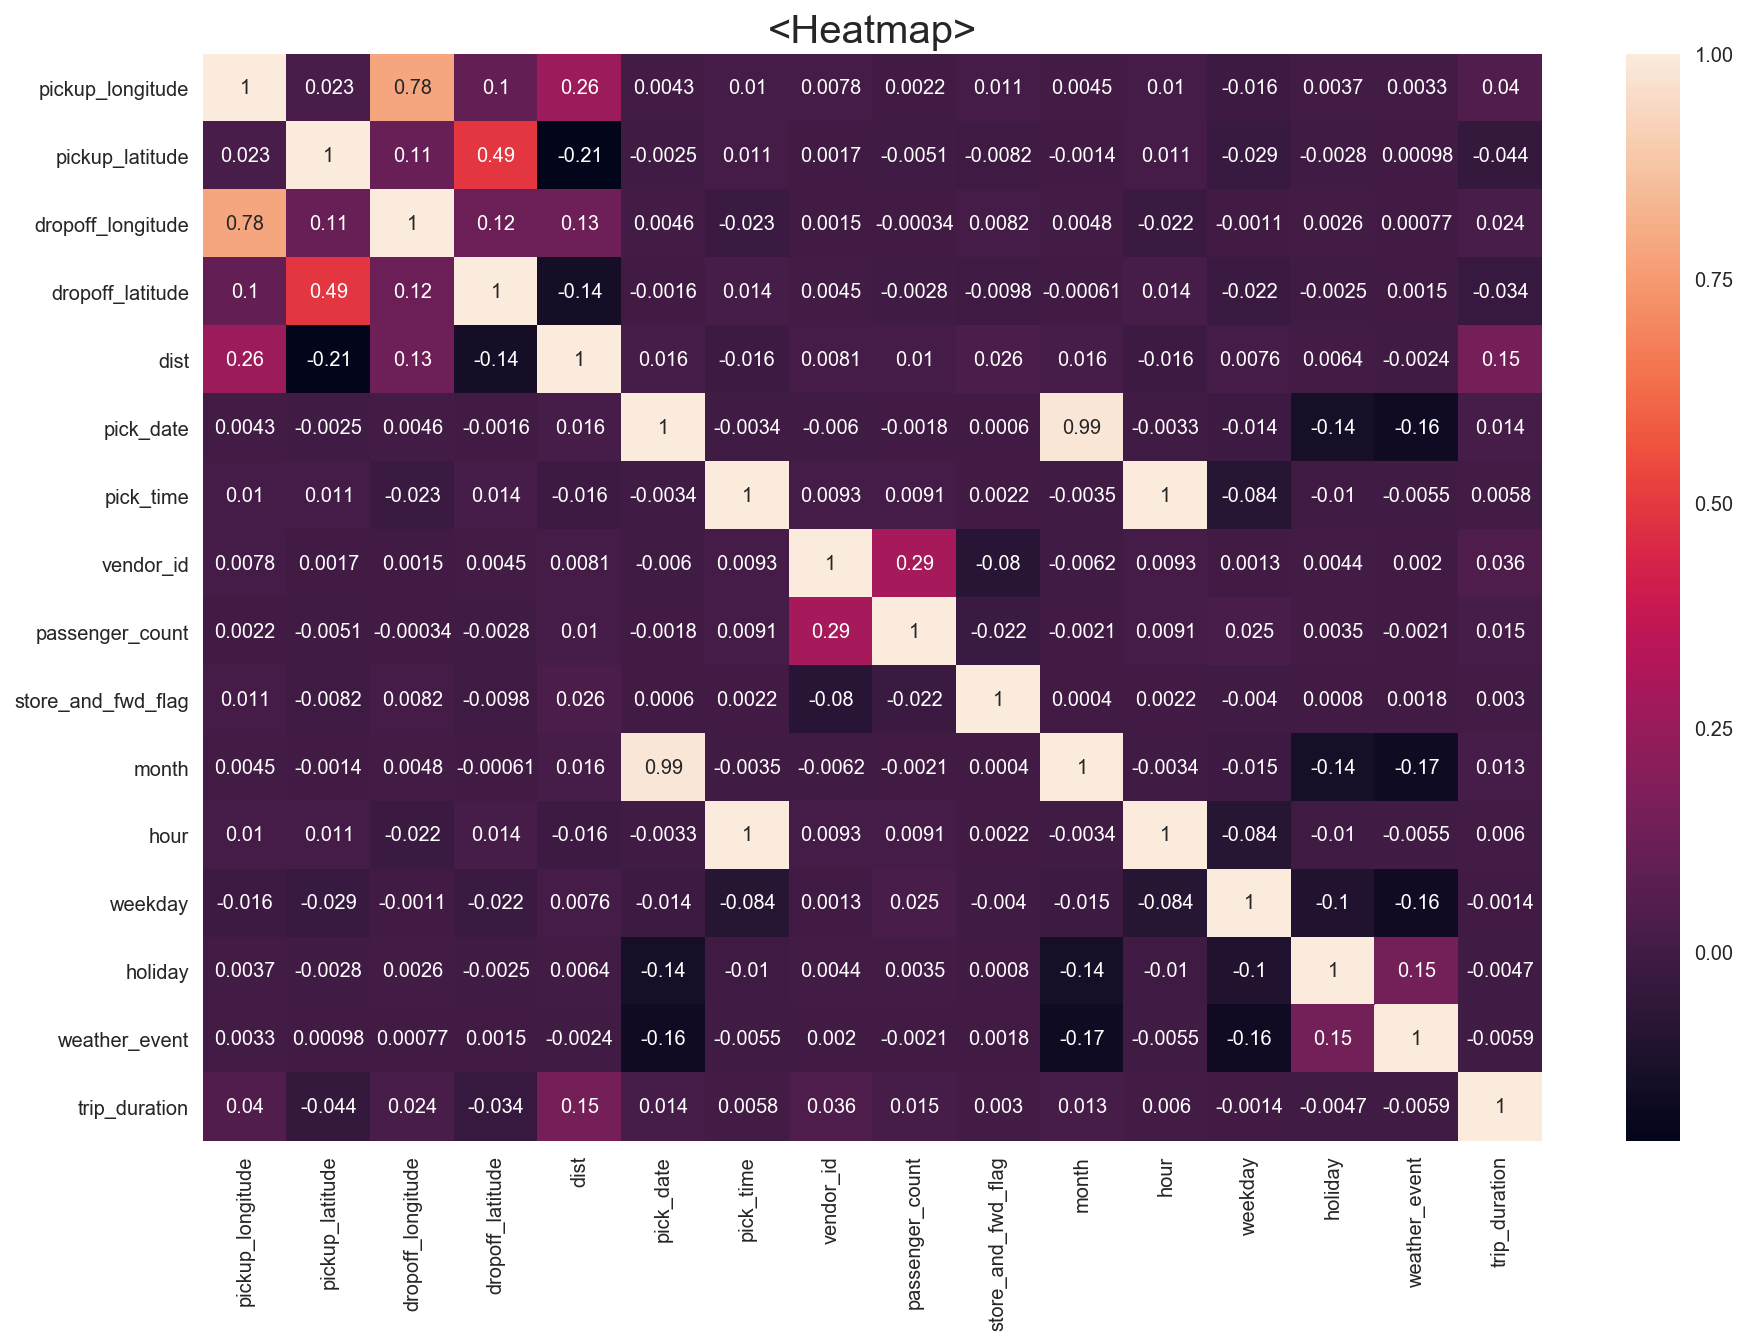

In [18]:
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(taxi.corr(), annot=True)
plt.title("<Heatmap>", fontsize = 20)

plt.show()

### b. pairplot

In [19]:
# 오래 걸려서 일단 패스
# taxi_pair = taxi.drop(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'pick_time', 'drop_time'], axis = 1)
# sns.pairplot(taxi_pair)

### c. VIF ( Variance Inflation Factor )

In [20]:
taxi_vif = taxi.drop(['trip_duration'], axis = 1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(taxi_vif.values, i) for i in range(taxi_vif.shape[1])]
vif["features"] = taxi_vif.columns
vif

,VIF Factor,features
0,2931146.94,pickup_longitude
1,1682155.58,pickup_latitude
2,2735707.59,dropoff_longitude
3,1477372.71,dropoff_latitude
4,1.71,dist
5,144.37,pick_date
6,2661.50,pick_time
7,11.48,vendor_id
8,2.84,passenger_count
9,1.01,store_and_fwd_flag


---

# 2. Rough modeling

In [21]:
feature_n, features = get_features(taxi, 0, -1)
model =  sm.OLS.from_formula("trip_duration ~ {}".format(features), data = taxi)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2474.
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        17:27:41   Log-Likelihood:            -1.3811e+07
No. Observations:             1458640   AIC:                         2.762e+07
Df Residuals:                 1458624   BIC:                         2.762e+07
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           9.003e+04   5102.728     17.643      0.000       8e+04       1e+05
pickup_longitude    -316.0879     61.211     -5.164      0.000    -436.060    -196.116
pickup_latitude     -944.1455     92.676    -10.188      0.000   -1125.788    -762.503
dropoff_longitude    555.4969     60.131      9.238      0.000     437.642     673.351
dropoff_latitude    -826.7761     83.789     -9.867      0.000    -991.000    -662.552
dist                 109.5650      0.646    169.521      0.000     108.298     110.832
pick_date              0.5617      0.298      1.883      0.060      -0.023       1.146
pick_time             -0.0057      0.002     -2.391      0.017      -0.010      -0.001
vendor_id            215.0803      5.445     39.502      0.000     204.409     225.752
passenger_count        8.4107      2.061      4.081      0.000       4.371      12.450
store_and_fwd_flag    71.1045     35.139      2.023      0.043       2.232     139.977
month                  1.7609      9.162      0.192      0.848     -16.196      19.718
hour                  24.7195      8.642      2.861      0.004       7.782      41.657
weekday               -5.6786      1.358     -4.182      0.000      -8.340      -3.017
holiday              -85.1786     17.003     -5.010      0.000    -118.503     -51.854
weather_event        -42.9735      9.329     -4.606      0.000     -61.259     -24.688
==============================================================================
Omnibus:                  3542578.659   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      29873663873.675
Skew:                          25.984   Prob(JB):                         0.00
Kurtosis:                     702.165   Cond. No.                     1.10e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## A. 잔차 정규성 검정

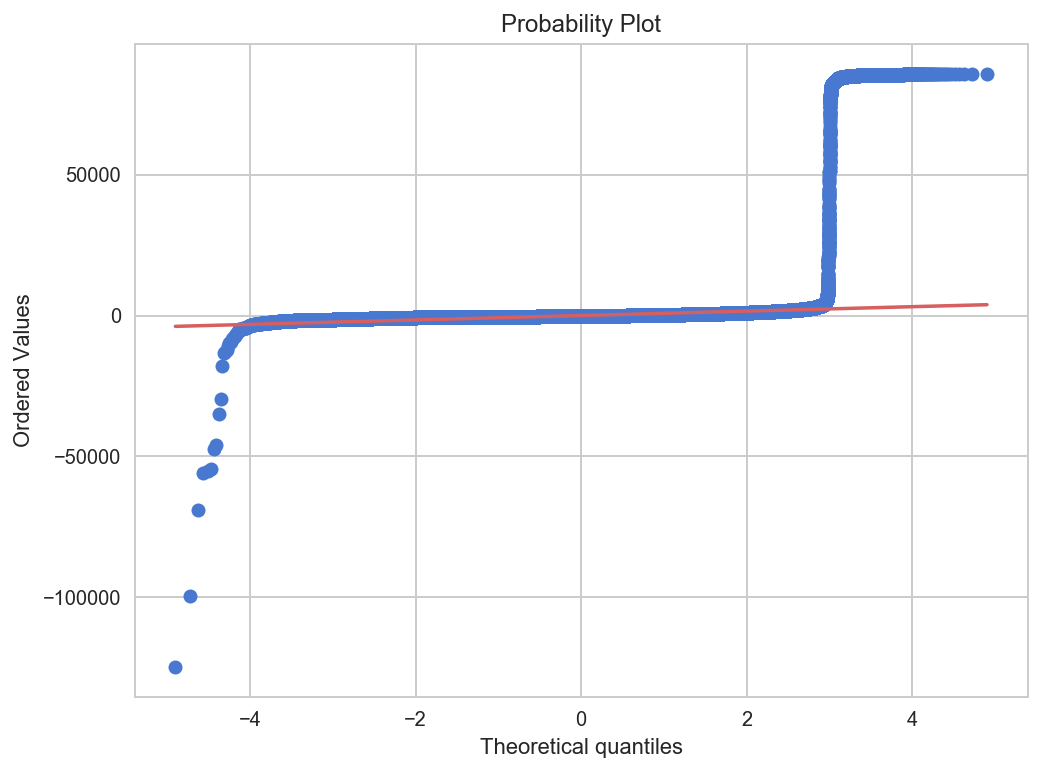

In [22]:
# probplot
f, ax = plt.subplots(figsize=(8, 6))
sp.stats.probplot(result.resid, plot = plt)

plt.show()

### residual-feature 관계 검정

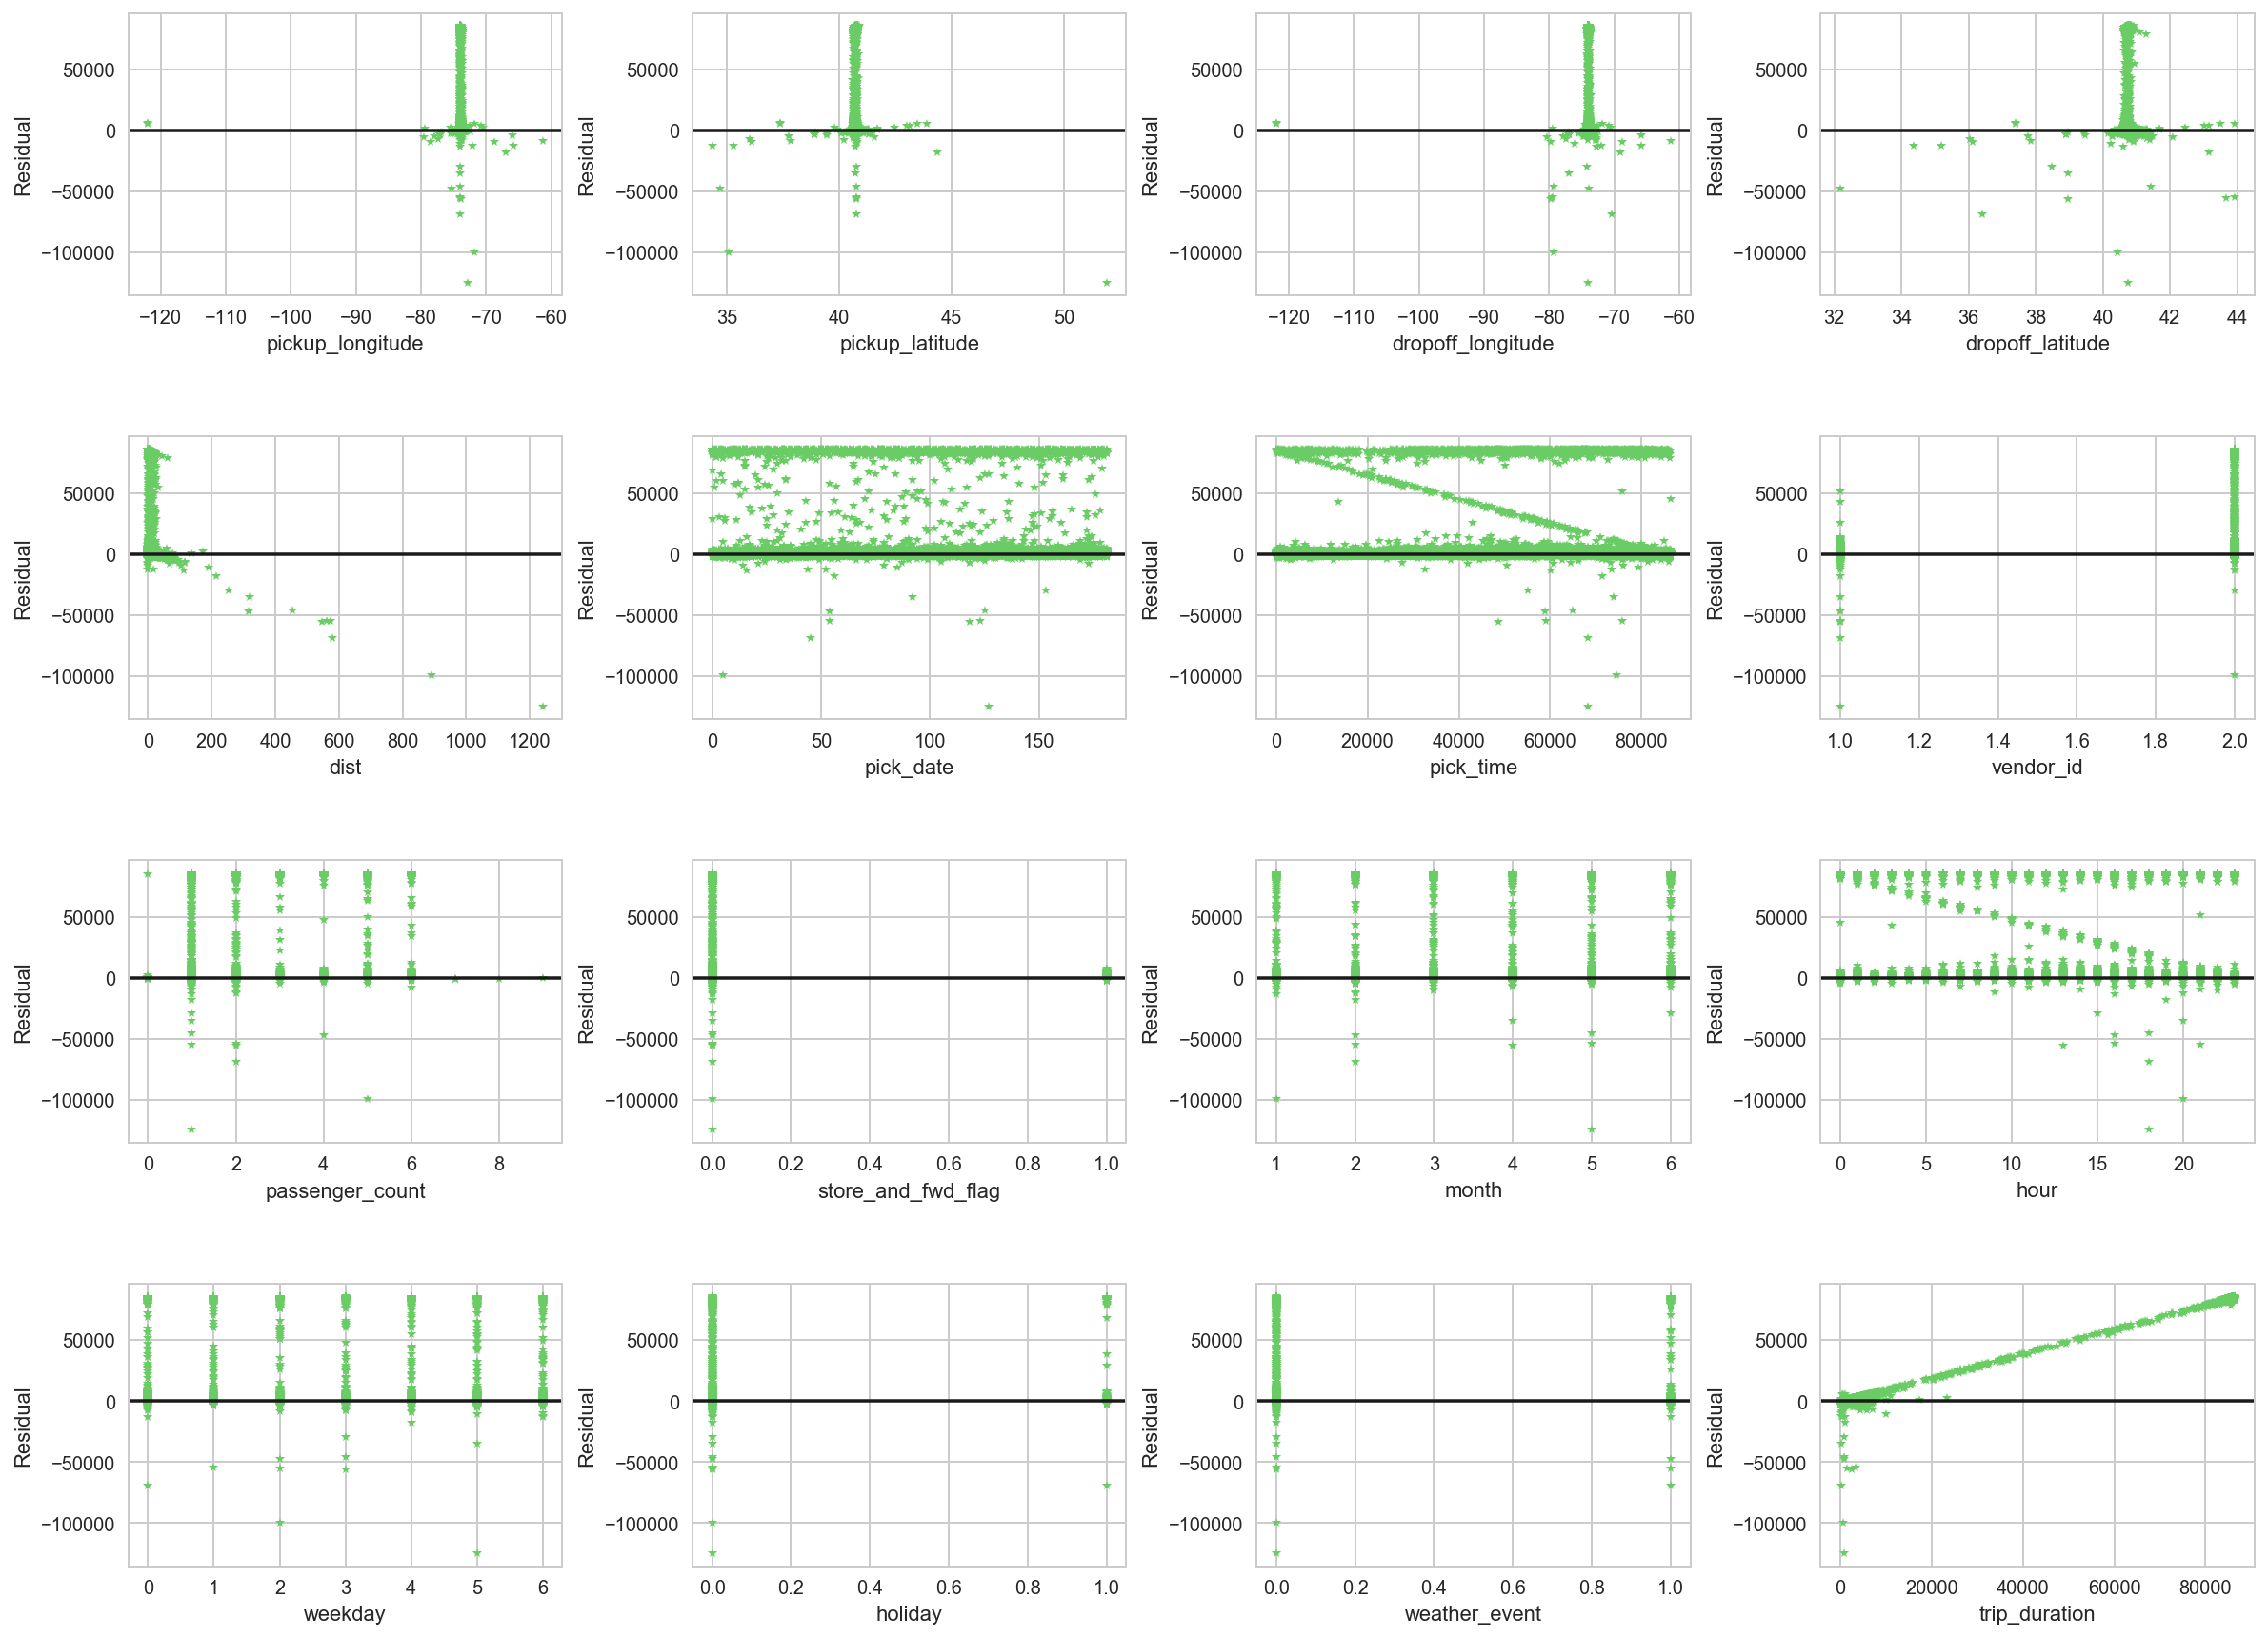

In [23]:
plt.figure(figsize=(20, 15))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

for i in range(1, 16+1):
    plt.subplot(4,4,i)
    plt.plot(taxi[taxi.columns[i-1]], result.resid, 'g*', markersize=5)
    plt.axhline(y=0, c='k')
    plt.xlabel(taxi.columns[i-1])
    plt.ylabel("Residual")

plt.show()

## B. 이분산 검정
feature 값이 증가함에 따른 y 값 분포 체크

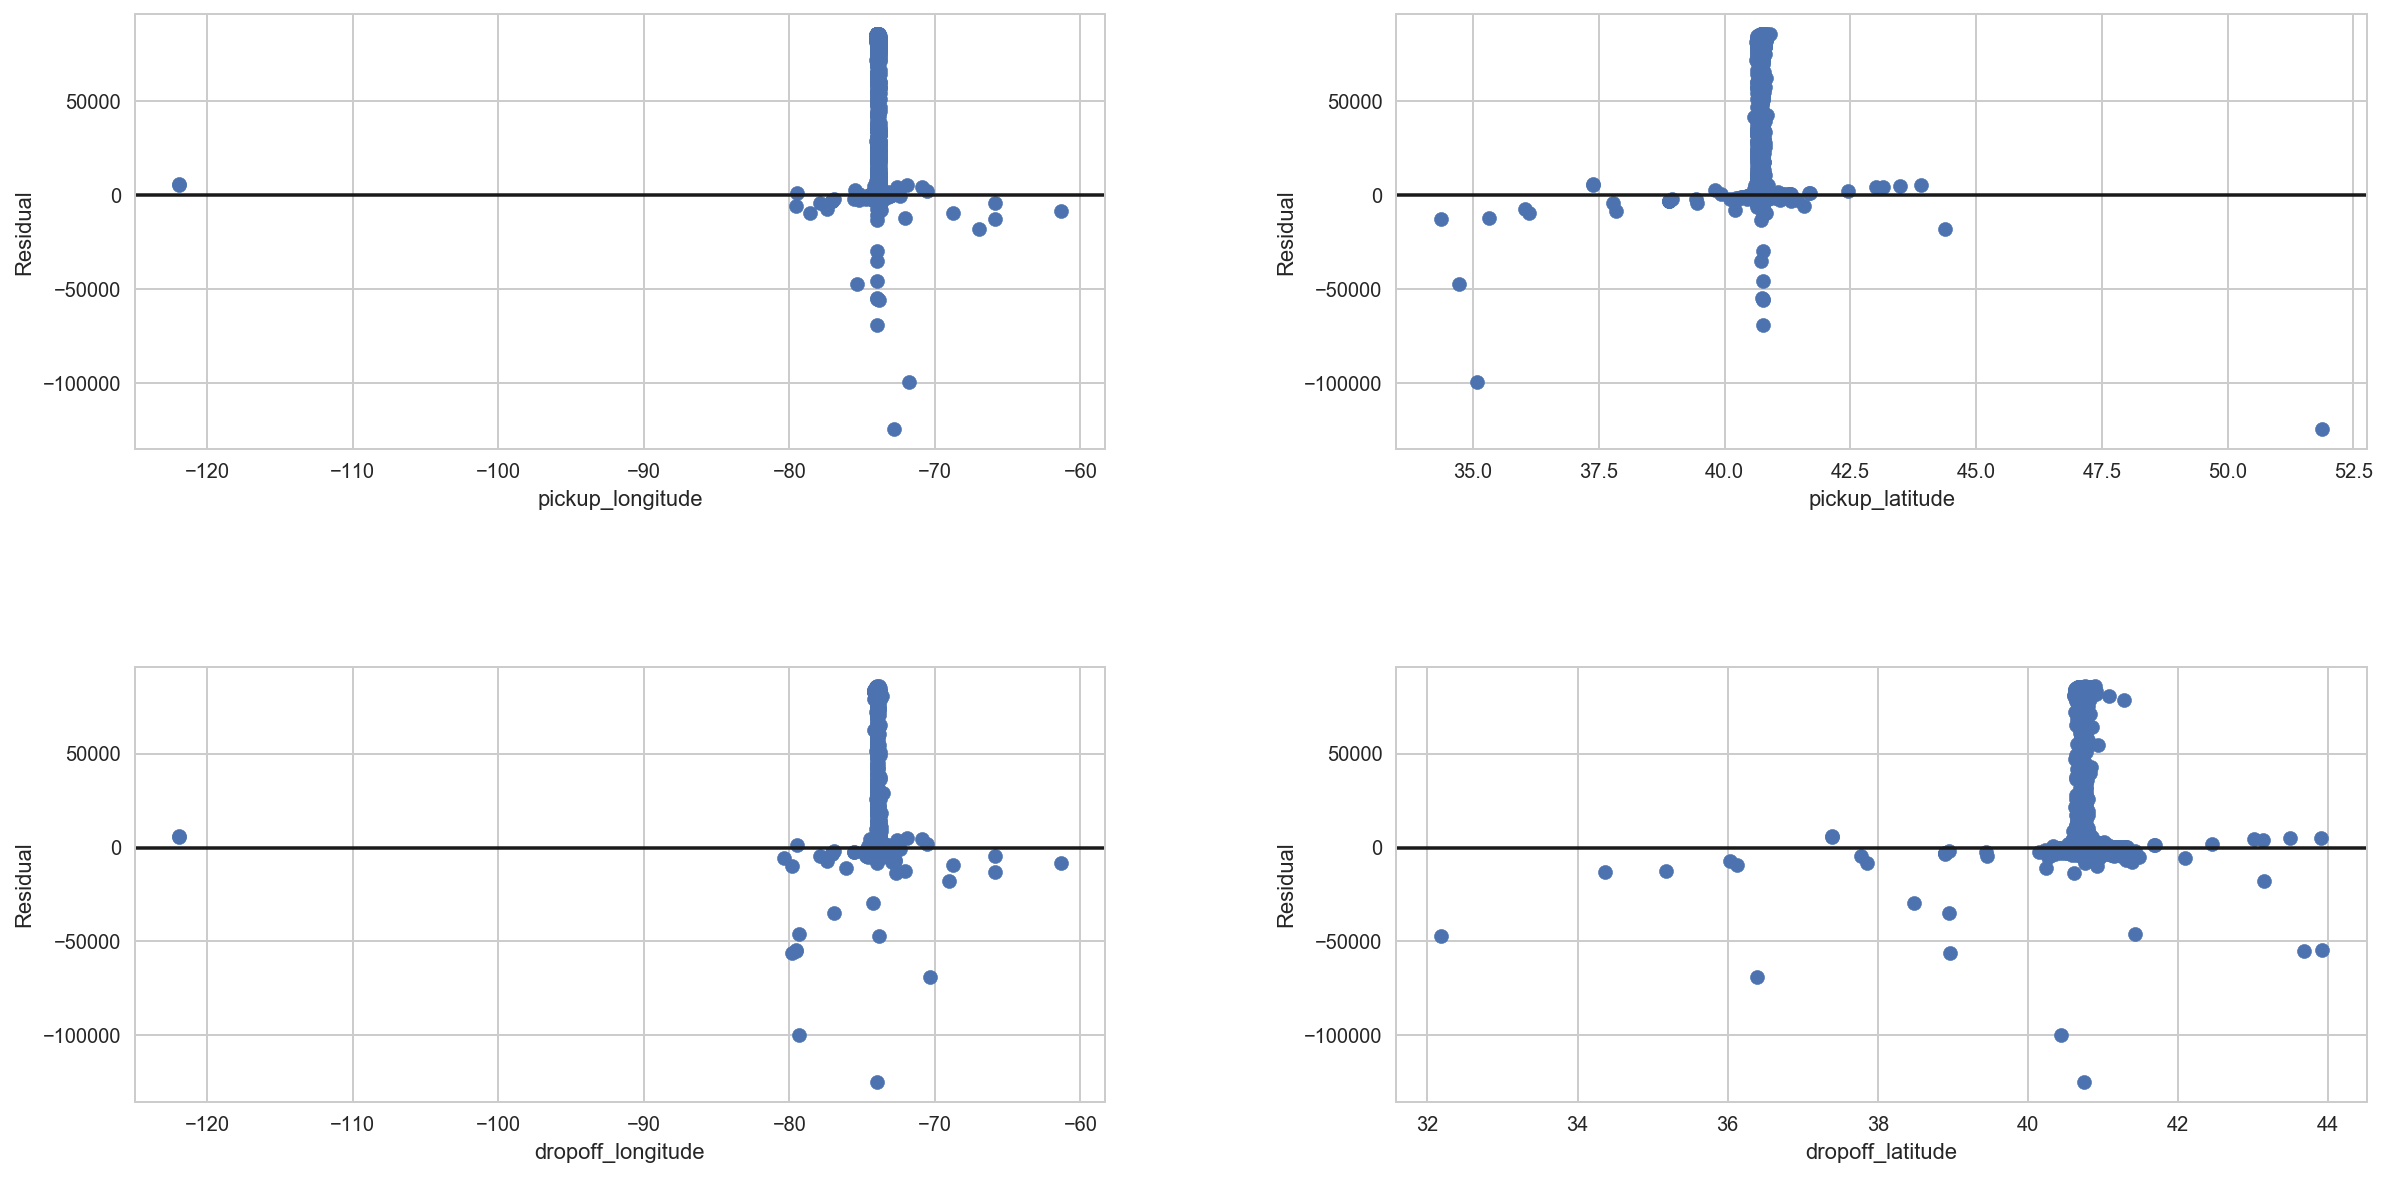

In [24]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

for i in range(1, 4+1):
    plt.subplot(2,2,i)
    plt.scatter(taxi[taxi.columns[i-1]], result.resid)
    plt.axhline(y=0, c='k')
    plt.xlabel(taxi.columns[i-1])
    plt.ylabel("Residual")

plt.show()

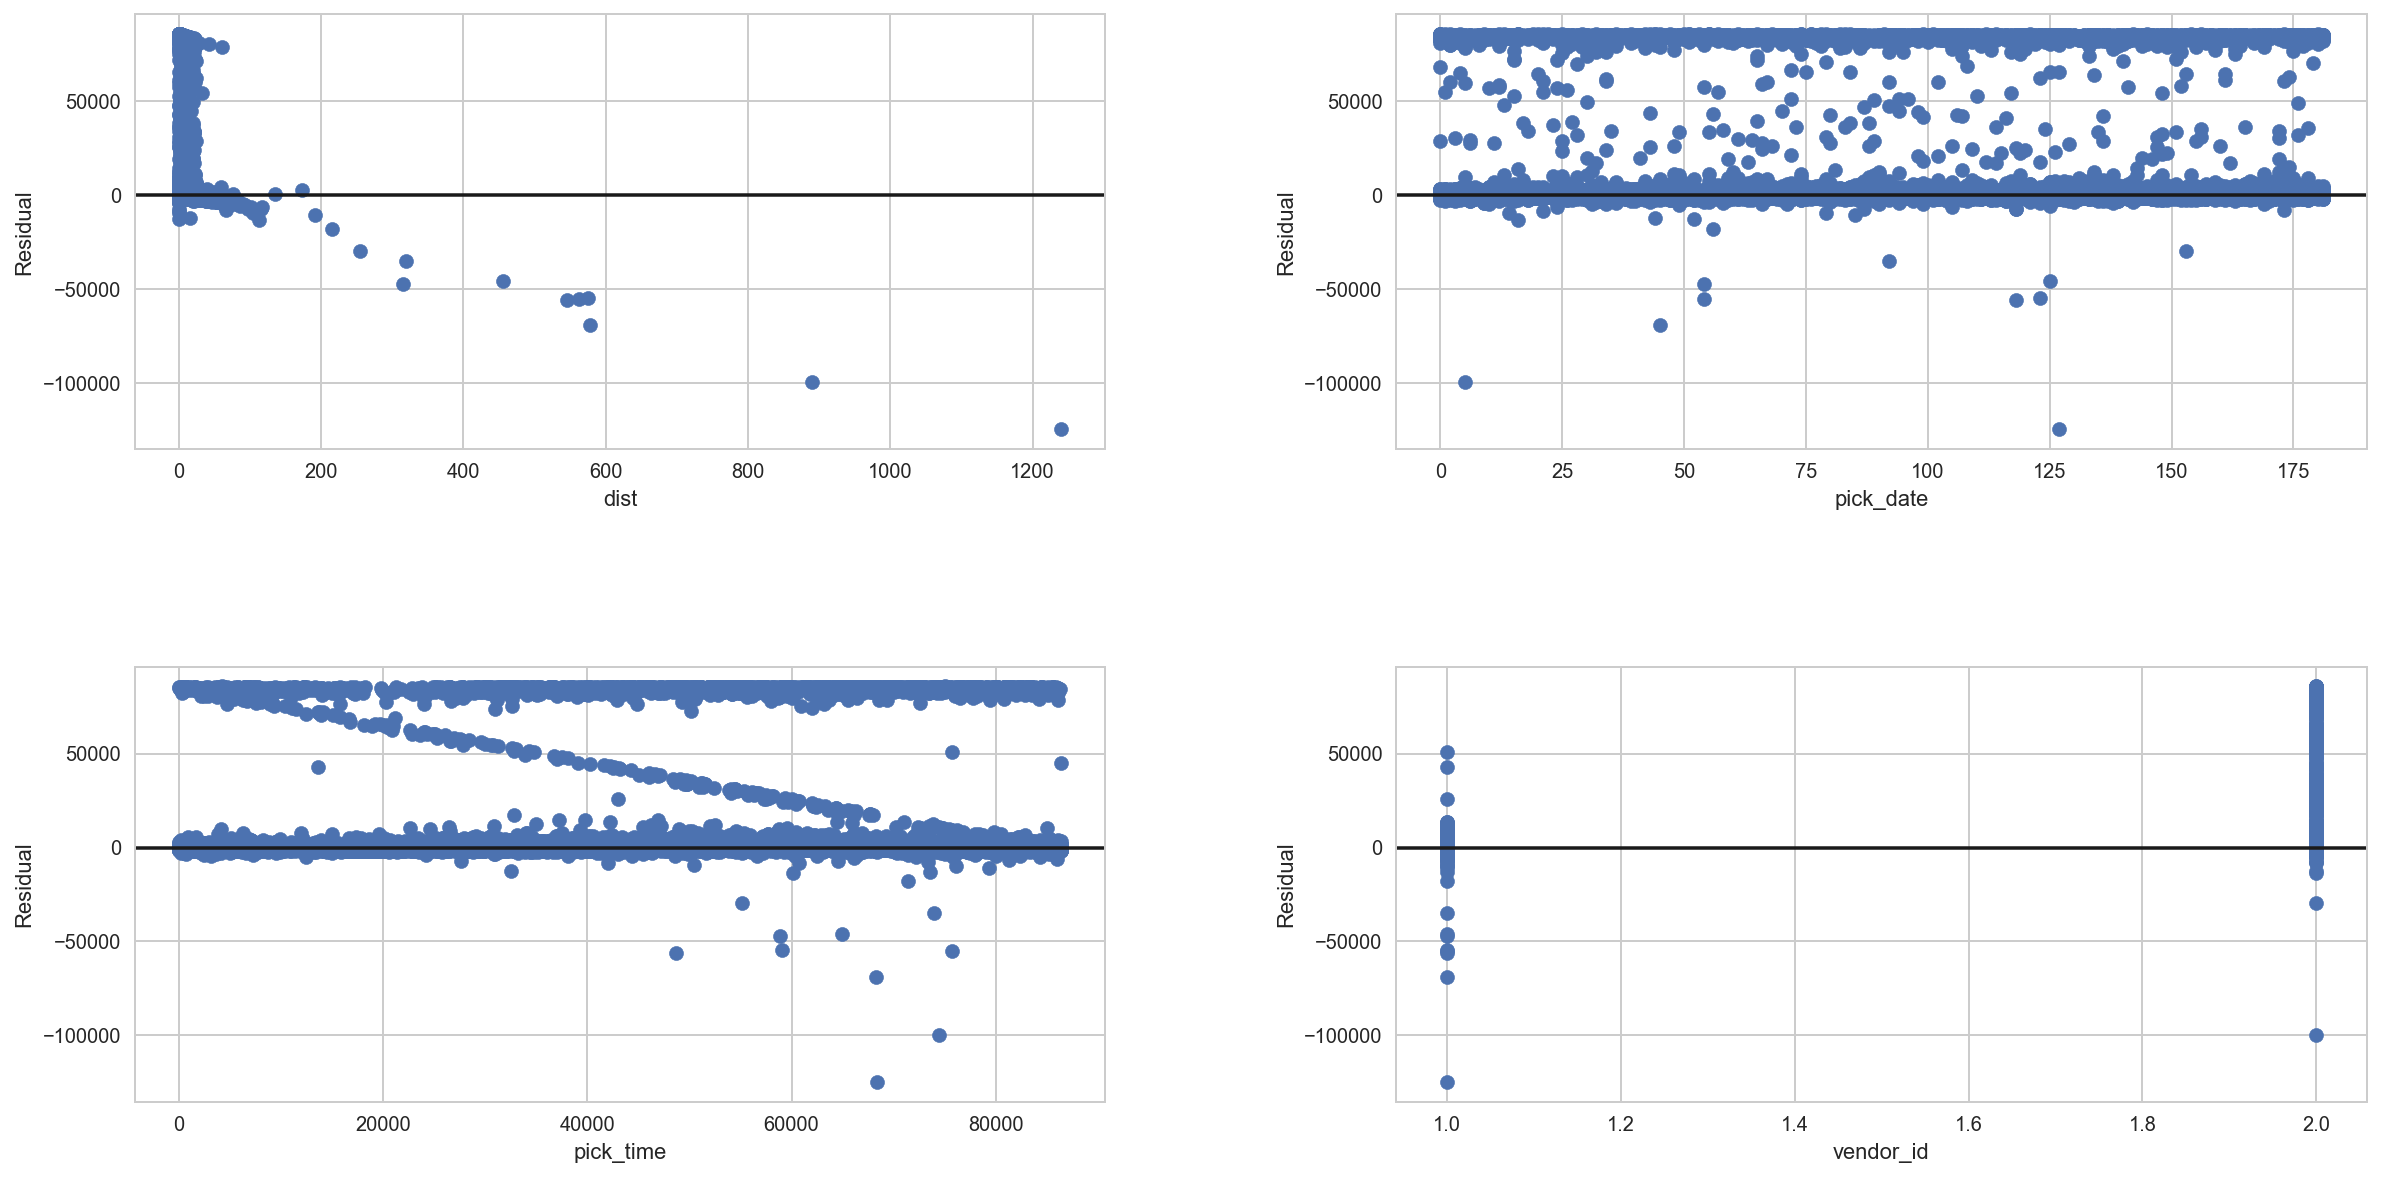

In [25]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

for i in range(5, 8+1):
    plt.subplot(2,2,i-4)
    plt.scatter(taxi[taxi.columns[i-1]], result.resid)
    plt.axhline(y=0, c='k')
    plt.xlabel(taxi.columns[i-1])
    plt.ylabel("Residual")

plt.show()

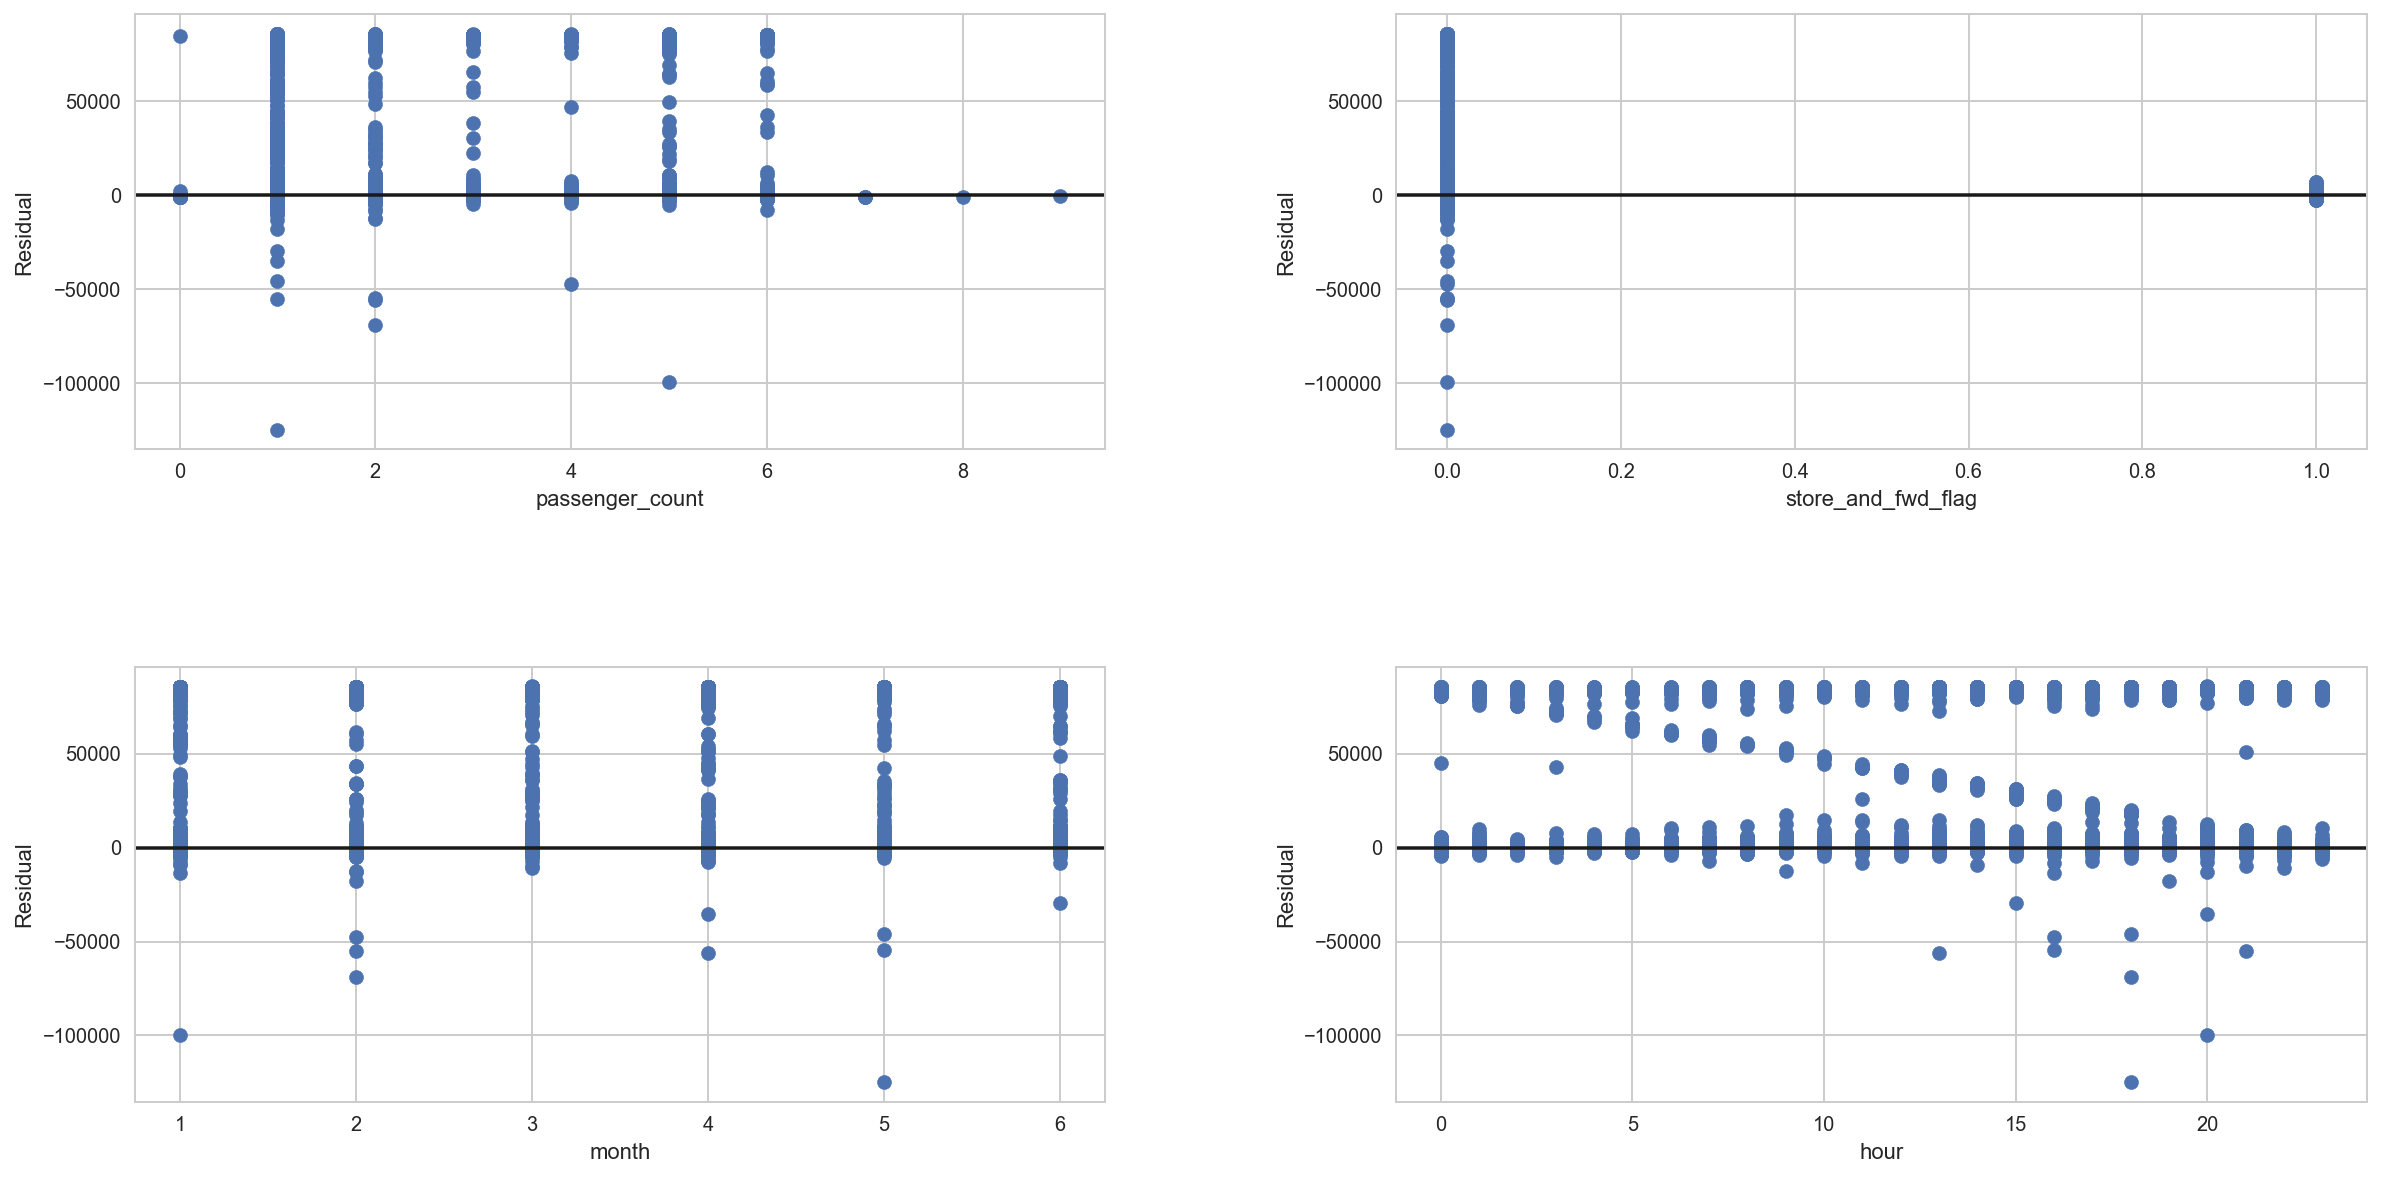

In [26]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

for i in range(9, 12+1):
    plt.subplot(2,2,i-8)
    plt.scatter(taxi[taxi.columns[i-1]], result.resid)
    plt.axhline(y=0, c='k')
    plt.xlabel(taxi.columns[i-1])
    plt.ylabel("Residual")

plt.show()

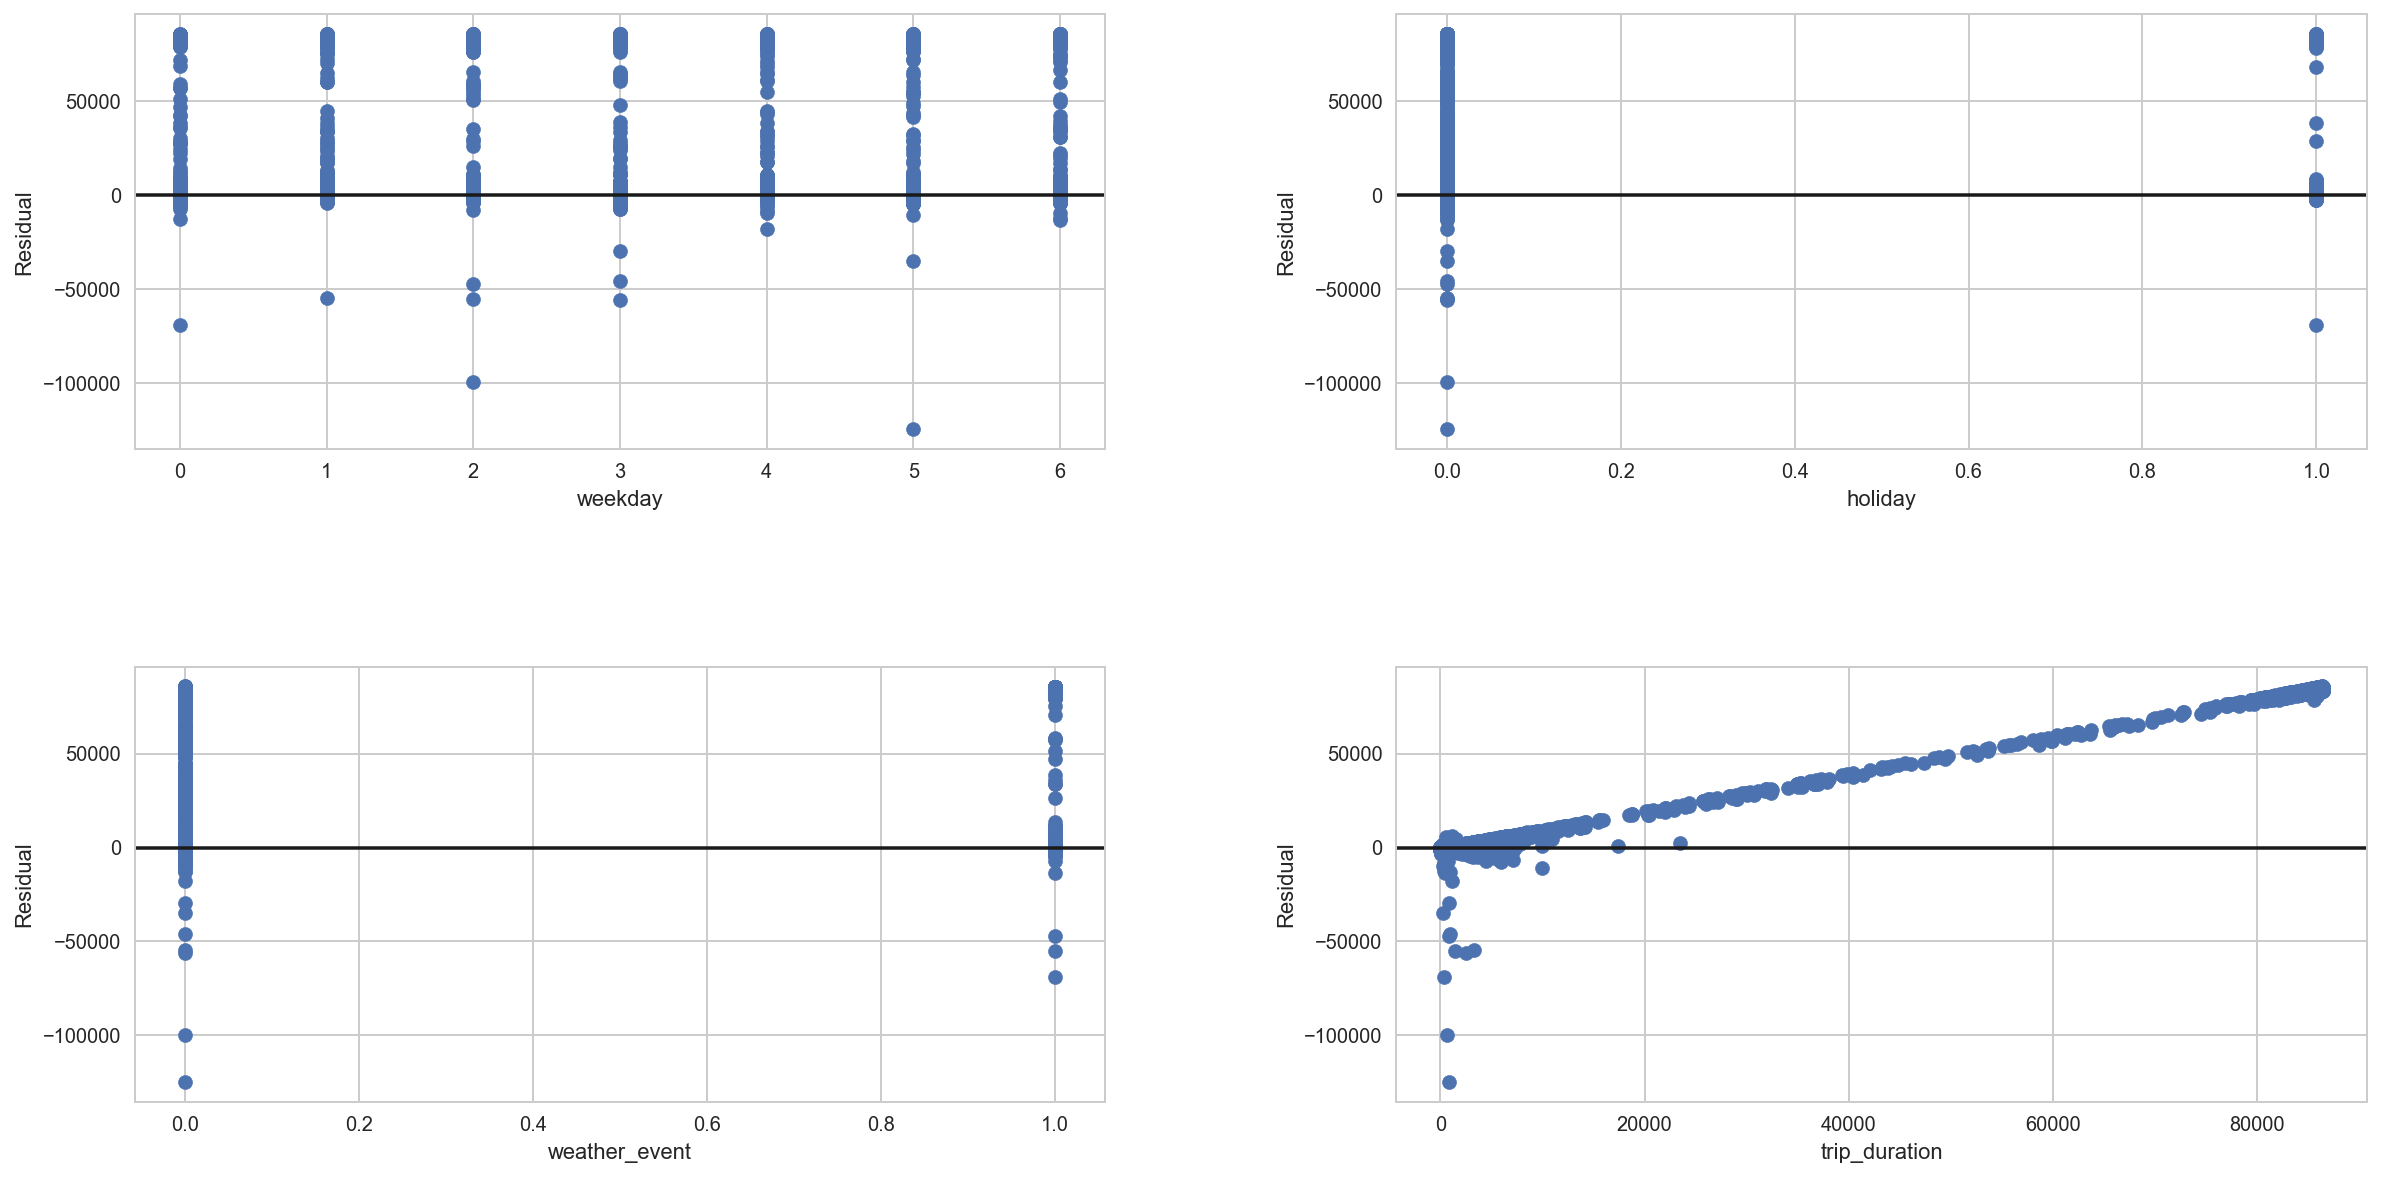

In [27]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

for i in range(13, 16+1):
    plt.subplot(2,2,i-12)
    plt.scatter(taxi[taxi.columns[i-1]], result.resid)
    plt.axhline(y=0, c='k')
    plt.xlabel(taxi.columns[i-1])
    plt.ylabel("Residual")

plt.show()

## C. 자기상관 검정

####  Durbin-Watson 검정

In [ ]:
# 값이 2 -> 무상관
durbin_watson(result.wresid)

2.0001604675420044

## D. Target-feature check

### partial regression 

In [ ]:
fig = plt.figure(figsize=(20, 40))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)
sm.graphics.plot_partregress_grid(result, fig=fig)
plt.show()

### ccpr

In [ ]:
fig = plt.figure(figsize=(20, 40))
sm.graphics.plot_ccpr_grid(result, fig=fig) 
fig.suptitle("")
plt.show()

---

# 3. Optimal regulize

각 컬럼별 최적 정규화
- 의미가 없는 경우 제거


1. dist
1. id
1. vendor_id
1. passenger_count
1. locations
1. store_and_fwd_flag
1. pick_date
1. pick_time
1. holiday
1. weekday
1. month
1. hour
1. weather_event

## dist

동수님 자리

---

성능이 준수한 `np.log(trip_duration) ~ scale(np.log1p(dist))` 기준으로 진행

In [12]:
#id
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log1p(dist))", data = taxi).fit(), result_sets,"default")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ id + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"id")
result_sets

KeyboardInterrupt: 

In [14]:
#vendor_id
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log1p(dist))", data = taxi).fit(), result_sets,"default")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ vendor_id + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"vendor_id")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ C(vendor_id)+scale(np.log1p(dist))", data = taxi).fit(), result_sets,"C(vendor_id)")
result_sets

,R-square,AIC,BIC,Cond.No.,Pb(Fstatics),Pb(omnibus),Pb(jb),Dub-Wat,Remarks
0,0.561,2286788.558,2286825.137,7.086,0.0,0.0,0.0,1.998,vendor_id
1,0.561,2286788.558,2286825.137,2.708,0.0,0.0,0.0,1.998,C(vendor_id)


In [ ]:
#passengercount
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log1p(dist))", data = taxi).fit(), result_sets,"default")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ passenger_count + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"passenger_count")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ C(passenger_count)+scale(np.log1p(dist))", data = taxi).fit(), result_sets,"C(passenger_count)")
result_sets

In [ ]:
#location
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log1p(dist))", data = taxi).fit(), result_sets,"default")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ pickup_longitude + pickup_latitude + dropoff_longitude+ dropoff_latitude + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"location")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ scale(pickup_longitude) + scale(pickup_latitude) + scale(dropoff_longitude)+ scale(dropoff_latitude) + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"scale(location)")
result_sets

In [ ]:
#store_and_fwd_flag
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log1p(dist))", data = taxi).fit(), result_sets,"default")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ store_and_fwd_flag + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"store_and_fwd_flag")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ C(store_and_fwd_flag) + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"C(store_and_fwd_flag)")
result_sets

In [ ]:
#pick_date
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log1p(dist))", data = taxi).fit(), result_sets,"default")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ pick_date + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"pick_date")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ scale(pick_date) + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"scale(pick_date)")
result_sets

In [ ]:
#pick_time
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log1p(dist))", data = taxi).fit(), result_sets,"default")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ pick_time + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"pick_time")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ scale(pick_time) + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"scale(pick_time)")
result_sets

In [ ]:
#holiday
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log1p(dist))", data = taxi).fit(), result_sets,"default")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ holiday + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"holiday")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ C(holiday) + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"C(holiday)")
result_sets

In [ ]:
#weekday
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log1p(dist))", data = taxi).fit(), result_sets,"default")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ weekday + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"weekday")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ C(weekday) + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"C(weekday)")
result_sets

In [ ]:
#month
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log1p(dist))", data = taxi).fit(), result_sets,"default")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ month + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"month")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ C(month) + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"C(month)")
result_sets

In [ ]:
#hour
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log1p(dist))", data = taxi).fit(), result_sets,"default")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ hour + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"hour")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ C(hour) + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"C(hour)")
result_sets

In [10]:
#weather_event
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log1p(dist))", data = taxi).fit(), result_sets,"default")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ weather_event + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"weather_event")
storage(sm.OLS.from_formula("np.log(trip_duration) ~ C(weather_event) + scale(np.log1p(dist))", data = taxi).fit(), result_sets,"C(weather_event)")
result_sets

In [11]:
result_sets

,R-square,AIC,BIC,Cond.No.,Pb(Fstatics),Pb(omnibus),Pb(jb),Dub-Wat,Remarks
0,0.561,2286788.558,2286825.137,7.086,0.0,0.0,0.0,1.998,vendor_id
1,0.561,2287442.482,2287466.868,1.000,0.0,0.0,0.0,1.998,w/o_vendor_id
2,0.561,2286788.558,2286825.137,2.708,0.0,0.0,0.0,1.998,C(vendor_id)
3,0.561,2286900.306,2286936.885,3.929,0.0,0.0,0.0,1.998,passenger_count
4,0.561,2287442.482,2287466.868,1.000,0.0,0.0,0.0,1.998,w/o_passenger_count
5,0.561,2285430.859,2285564.983,1551.404,0.0,0.0,0.0,1.998,C(passenger_count)
6,0.564,2274662.913,2274736.071,233397.305,0.0,0.0,0.0,1.999,location
7,0.561,2287442.482,2287466.868,1.000,0.0,0.0,0.0,1.998,w/o_location
8,0.564,2274662.913,2274736.071,3.012,0.0,0.0,0.0,1.999,scale(location)
9,0.561,2287427.141,2287463.720,13.507,0.0,0.0,0.0,1.998,store_and_fwd_flag


---

# Modeling

#### basic model
- with outlier
- without outlier

#### model with extra data ( weather, gasoline )
- with outlier
- without outlier

In [ ]:
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.", "Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])

## basic model

In [ ]:
model = sm.OLS.from_formula("trip_duration ~ ", data = taxi) # data 수정 필요
result1 = model.fit()
storage(result1, result_sets, 'basic')

## basic model w/o outlier

In [ ]:
basic_filtered, dropped = erase_outlier_np(result, taxi, category=True, dropped=True)

In [ ]:
model = sm.OLS.from_formula("trip_duration ~ {}", data = basic_filtered)
result2 = model.fit()
storage(result2, result_sets, 'basic_w/o_outlier')

# 비교

In [ ]:
result_sets

결과 진단

In [ ]:
result.summary() # 가장 좋은 데이터 1개

잔차 정규성

In [ ]:
# probplot
f, ax = plt.subplots(figsize=(8, 6))
sp.stats.probplot(result.resid, plot = plt)
plt.show()

이분산 검정

In [ ]:
plt.scatter(taxi['pick_date'], result.resid)
plt.show()

자기상관

In [ ]:
durbin_watson(result.wresid)

---

# Cross validation
- score: kaggle 기준 (Root Mean Squared Logarithmic Error)

    - 현재 항목은 test용으로 넣어놓음/ 모델링 항목에서 만든 최적 모델 시행


In [7]:
score, result_set = cross_validater("np.log(trip_duration) ~ np.log1p(dist)", taxi, 3, r_seed=3)

In [8]:
result_set

,R-square,AIC,BIC,Cond.No.,Pb(Fstatics),Pb(omnibus),Pb(jb),Dub-Wat,Remarks
0,0.561,1525722.234,1525745.809,4.509,0.0,0.0,0.0,1.998,np.log(trip_duration) ~ np.log1p(dist)
1,0.561,1524005.249,1524028.824,4.506,0.0,0.0,0.0,1.995,np.log(trip_duration) ~ np.log1p(dist)
2,0.560,1526681.469,1526705.044,4.511,0.0,0.0,0.0,1.998,np.log(trip_duration) ~ np.log1p(dist)


In [9]:
score

[4.5195665055377354, 4.5213004381479589, 4.5210229385907814]

In [21]:
score, result_set = cross_validater("np.log(trip_duration) ~  scale(pick_time) + scale(np.log1p(dist))", taxi, 3, r_seed=3)

In [22]:
result_set

,R-square,AIC,BIC,Cond.No.,Pb(Fstatics),Pb(omnibus),Pb(jb),Dub-Wat,Remarks
0,0.563,1519794.508,1519829.871,1.017,0.0,0.0,0.0,1.998,np.log(trip_duration) ~ scale(pick_time) + sc...
1,0.563,1517826.471,1517861.834,1.020,0.0,0.0,0.0,1.994,np.log(trip_duration) ~ scale(pick_time) + sc...
2,0.562,1520688.727,1520724.090,1.018,0.0,0.0,0.0,1.998,np.log(trip_duration) ~ scale(pick_time) + sc...


In [23]:
score # 

[4.5195477519732119, 4.5212650356815294, 4.5209783577489917]

---

# Kaggle result

In [ ]:
kaggle = pd.read_csv("test_taxi.csv")

In [ ]:
y_hat = result.predict(kaggle)
y_hat = y_hat.apply(lambda x: int(round(np.exp(x))))
ans = pd.concat([kaggle['id'], y_hat], axis=1)
ans.rename(columns={'id':'id' , 0:'trip_duration'}, inplace=True)
ans.tail()

In [ ]:
# import math
# ans['trip_duration'] = ans['trip_duration'].apply(lambda x: 0 if math.isnan(x) else x)

In [ ]:
ans.to_csv('answer.csv', index=False)

결과 : 

---

# Conclusion